<a href="https://colab.research.google.com/github/AaqibZ/DiffusionModels/blob/main/Difusion_GuideExp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IC Seeds: {0, 12, 21, 6}
LT Seeds: {28, 20, 22, 6}
Total IC activated nodes: 6
Total LT activated nodes: 17


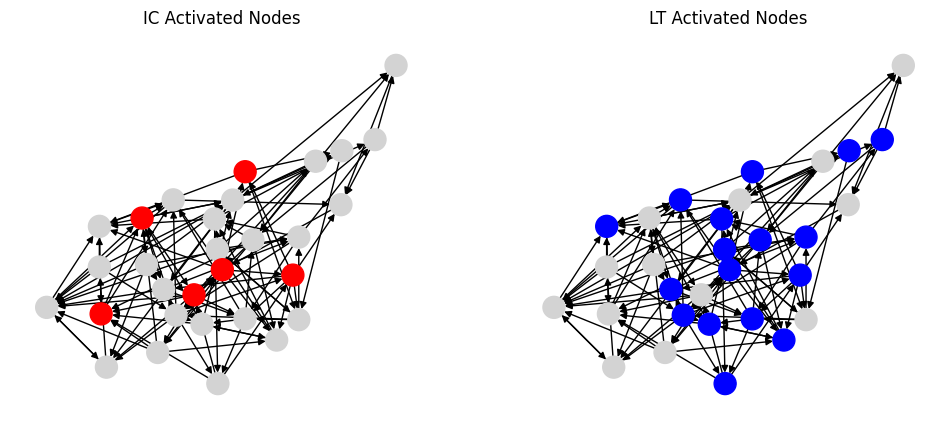

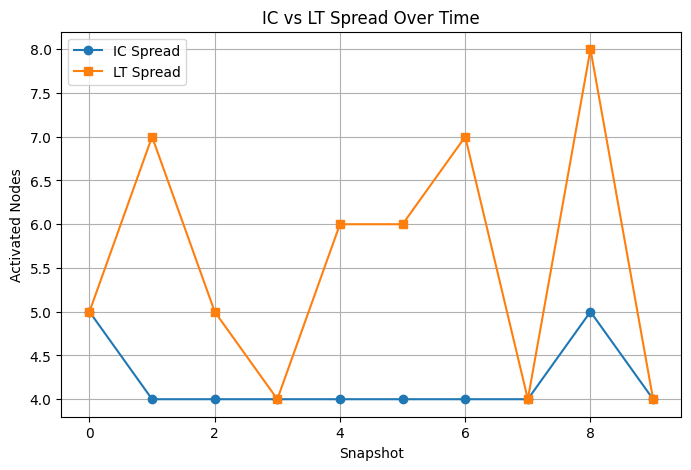

In [9]:
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# PARAMETERS
# -------------------------------
N_NODES = 30
N_EDGES = 120
T = 10          # number of snapshots
K = 4           # number of seeds
IC_PROB = 0.1
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# -------------------------------
# 1. TEMPORAL NETWORK GENERATION
# -------------------------------
def generate_temporal_network(n_nodes, n_edges, T):
    edges = []
    for _ in range(n_edges):
        u, v = random.sample(range(n_nodes), 2)
        t = random.randint(0, T - 1)
        edges.append((u, v, t))
    return edges

# -------------------------------
# 2. BUILD SNAPSHOTS
# -------------------------------
def build_snapshots(temporal_edges, n_nodes, T):
    snapshots = []
    for t in range(T):
        G = nx.DiGraph()
        G.add_nodes_from(range(n_nodes))
        for u, v, time in temporal_edges:
            if time == t:
                G.add_edge(u, v)
        snapshots.append(G)
    return snapshots

# -------------------------------
# 3. DIFFUSION MODELS
# -------------------------------
def independent_cascade(G, seeds, p=0.1):
    active = set(seeds) & set(G.nodes())
    newly_active = set(active)

    while newly_active:
        next_active = set()
        for u in newly_active:
            for v in G.successors(u):
                if v not in active and random.random() <= p:
                    next_active.add(v)
        newly_active = next_active
        active |= newly_active

    return active

def linear_threshold(G, seeds):
    active = set(seeds) & set(G.nodes())
    thresholds = {v: random.random() for v in G.nodes()}

    while True:
        new_active = set()
        for v in G.nodes():
            if v in active:
                continue
            in_neighbors = list(G.predecessors(v))
            if not in_neighbors:
                continue
            influence = sum(1 for u in in_neighbors if u in active)
            if influence >= thresholds[v] * len(in_neighbors):
                new_active.add(v)
        if not new_active:
            break
        active |= new_active

    return active

# -------------------------------
# 4. GREEDY SEED SELECTION
# -------------------------------
def greedy_seed_selection(G, k, model="IC", runs=5):
    seeds = set()

    for _ in range(k):
        best_node = None
        best_spread = -1

        for v in G.nodes():
            if v in seeds:
                continue

            spreads = []
            for _ in range(runs):
                if model == "IC":
                    spread = len(independent_cascade(G, seeds | {v}, IC_PROB))
                else:
                    spread = len(linear_threshold(G, seeds | {v}))
                spreads.append(spread)

            avg_spread = np.mean(spreads)
            if avg_spread > best_spread:
                best_spread = avg_spread
                best_node = v

        seeds.add(best_node)

    return seeds

# -------------------------------
# 5. VISUALIZE SNAPSHOTS
# -------------------------------
def plot_snapshots(snapshots):
    plt.figure(figsize=(15, 8))
    pos = nx.spring_layout(snapshots[0], seed=RANDOM_SEED)

    for i, G in enumerate(snapshots):
        plt.subplot(2, 5, i + 1)
        nx.draw(
            G, pos,
            node_size=200,
            node_color="lightgray",
            edge_color="gray",
            with_labels=False
        )
        plt.title(f"Snapshot {i}")

    plt.tight_layout()
    plt.show()

# -------------------------------
# 6. MAIN EXPERIMENT
# -------------------------------
temporal_edges = generate_temporal_network(N_NODES, N_EDGES, T)
snapshots = build_snapshots(temporal_edges, N_NODES, T)

# Aggregate graph for seed selection
G_agg = nx.DiGraph()
G_agg.add_nodes_from(range(N_NODES))
for G in snapshots:
    G_agg.add_edges_from(G.edges())

# Select seeds
seeds_ic = greedy_seed_selection(G_agg, K, model="IC")
seeds_lt = greedy_seed_selection(G_agg, K, model="LT")

print("IC Seeds:", seeds_ic)
print("LT Seeds:", seeds_lt)

# -------------------------------
# 7. RUN DIFFUSION OVER TIME
# -------------------------------
ic_spread_over_time = []
lt_spread_over_time = []

ic_active_all = set()
lt_active_all = set()

for G in snapshots:
    ic_active = independent_cascade(G, seeds_ic, IC_PROB)
    lt_active = linear_threshold(G, seeds_lt)

    ic_active_all |= ic_active
    lt_active_all |= lt_active

    ic_spread_over_time.append(len(ic_active))
    lt_spread_over_time.append(len(lt_active))

print("Total IC activated nodes:", len(ic_active_all))
print("Total LT activated nodes:", len(lt_active_all))

# -------------------------------
# 8. VISUALIZE FINAL ACTIVATIONS
# -------------------------------
plt.figure(figsize=(12, 5))
pos = nx.spring_layout(G_agg, seed=RANDOM_SEED)

plt.subplot(1, 2, 1)
nx.draw(G_agg, pos,
        node_color=["red" if n in ic_active_all else "lightgray" for n in G_agg.nodes()],
        node_size=250,
        with_labels=False)
plt.title("IC Activated Nodes")

plt.subplot(1, 2, 2)
nx.draw(G_agg, pos,
        node_color=["blue" if n in lt_active_all else "lightgray" for n in G_agg.nodes()],
        node_size=250,
        with_labels=False)
plt.title("LT Activated Nodes")

plt.show()

# -------------------------------
# 9. IC vs LT COMPARISON PLOT
# -------------------------------
plt.figure(figsize=(8, 5))
plt.plot(range(T), ic_spread_over_time, marker="o", label="IC Spread")
plt.plot(range(T), lt_spread_over_time, marker="s", label="LT Spread")
plt.xlabel("Snapshot")
plt.ylabel("Activated Nodes")
plt.title("IC vs LT Spread Over Time")
plt.legend()
plt.grid(True)
plt.show()



Selected Seed Nodes
-------------------
IC Seeds: {8, 25, 2, 23}
LT Seeds: {8, 1, 4, 13}

Snapshot-wise Activated Nodes
-----------------------------
Snapshot | IC Active | LT Active
   1     |     4     |     6    
   2     |     6     |     9    
   3     |     8     |    18    
   4     |    10     |    26    
   5     |    11     |    28    
   6     |    13     |    30    
   7     |    14     |    30    
   8     |    17     |    30    
   9     |    18     |    30    
   10    |    19     |    30    

Final Activated Nodes
---------------------
Total IC activated nodes: 19
Total LT activated nodes: 30


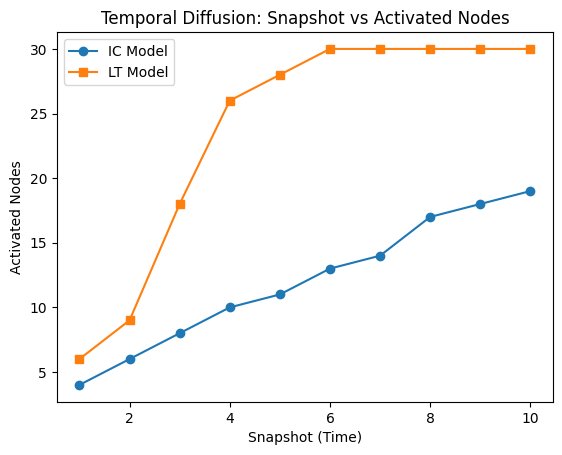

In [13]:
import networkx as nx
import random
import matplotlib.pyplot as plt

# -------------------------------
# 1. Generate Temporal Network
# -------------------------------
def generate_temporal_network(n=30, snapshots=10, p=0.08):
    return [nx.erdos_renyi_graph(n, p, seed=t) for t in range(snapshots)]

def aggregate_network(temporal_graphs):
    G = nx.Graph()
    for Tg in temporal_graphs:
        G.add_edges_from(Tg.edges())
    return G

# -------------------------------
# 2. IC and LT Models (One-step)
# -------------------------------
def ic_step(G, active, p=0.1):
    new_active = set(active)
    for u in active:
        if u not in G:
            continue
        for v in G.neighbors(u):
            if v not in new_active and random.random() < p:
                new_active.add(v)
    return new_active

def lt_step(G, active, thresholds):
    new_active = set(active)
    for v in G.nodes():
        if v in new_active:
            continue
        nbrs = list(G.neighbors(v))
        if not nbrs:
            continue
        frac = sum(1 for u in nbrs if u in new_active) / len(nbrs)
        if frac >= thresholds[v]:
            new_active.add(v)
    return new_active

# -------------------------------
# 3. Model-dependent Greedy Seeds
# -------------------------------
def greedy_ic(G, k, mc=10):
    seeds = set()
    for _ in range(k):
        best, best_gain = None, -1
        for v in G.nodes():
            if v in seeds:
                continue
            gain = 0
            for _ in range(mc):
                gain += len(simulate_ic(G, seeds | {v}))
            gain /= mc
            if gain > best_gain:
                best, best_gain = v, gain
        seeds.add(best)
    return seeds

def greedy_lt(G, k, mc=10):
    seeds = set()
    for _ in range(k):
        best, best_gain = None, -1
        for v in G.nodes():
            if v in seeds:
                continue
            gain = 0
            for _ in range(mc):
                gain += len(simulate_lt(G, seeds | {v}))
            gain /= mc
            if gain > best_gain:
                best, best_gain = v, gain
        seeds.add(best)
    return seeds

# Full simulations (used only for greedy)
def simulate_ic(G, seeds, p=0.1):
    active, frontier = set(seeds), set(seeds)
    while frontier:
        new = set()
        for u in frontier:
            for v in G.neighbors(u):
                if v not in active and random.random() < p:
                    new.add(v)
        frontier = new
        active |= frontier
    return active

def simulate_lt(G, seeds):
    thresholds = {v: random.uniform(0.3, 0.6) for v in G.nodes()}
    active = set(seeds)
    changed = True
    while changed:
        changed = False
        for v in G.nodes():
            if v in active:
                continue
            nbrs = list(G.neighbors(v))
            if not nbrs:
                continue
            frac = sum(1 for u in nbrs if u in active) / len(nbrs)
            if frac >= thresholds[v]:
                active.add(v)
                changed = True
    return active

# -------------------------------
# 4. Main Experiment
# -------------------------------
random.seed(42)

T = 10
k = 4

temporal_graphs = generate_temporal_network(snapshots=T)
G_agg = aggregate_network(temporal_graphs)

# Select seeds
ic_seeds = greedy_ic(G_agg, k)
lt_seeds = greedy_lt(G_agg, k)

print("\nSelected Seed Nodes")
print("-------------------")
print("IC Seeds:", ic_seeds)
print("LT Seeds:", lt_seeds)

# Initial active sets
ic_active = set(ic_seeds)
lt_active = set(lt_seeds)

lt_thresholds = {v: random.uniform(0.3, 0.6) for v in G_agg.nodes()}

ic_counts = []
lt_counts = []

# -------------------------------
# 5. Snapshot-wise Diffusion
# -------------------------------
print("\nSnapshot-wise Activated Nodes")
print("-----------------------------")
print("Snapshot | IC Active | LT Active")

for t in range(T):
    Gt = temporal_graphs[t]

    ic_active = ic_step(Gt, ic_active)
    lt_active = lt_step(Gt, lt_active, lt_thresholds)

    ic_counts.append(len(ic_active))
    lt_counts.append(len(lt_active))

    print(f"{t+1:^8} | {len(ic_active):^9} | {len(lt_active):^9}")

print("\nFinal Activated Nodes")
print("---------------------")
print("Total IC activated nodes:", len(ic_active))
print("Total LT activated nodes:", len(lt_active))

# -------------------------------
# 6. Plot
# -------------------------------
plt.figure()
plt.plot(range(1, T+1), ic_counts, marker='o', label="IC Model")
plt.plot(range(1, T+1), lt_counts, marker='s', label="LT Model")
plt.xlabel("Snapshot (Time)")
plt.ylabel("Activated Nodes")
plt.title("Temporal Diffusion: Snapshot vs Activated Nodes")
plt.legend()
plt.show()


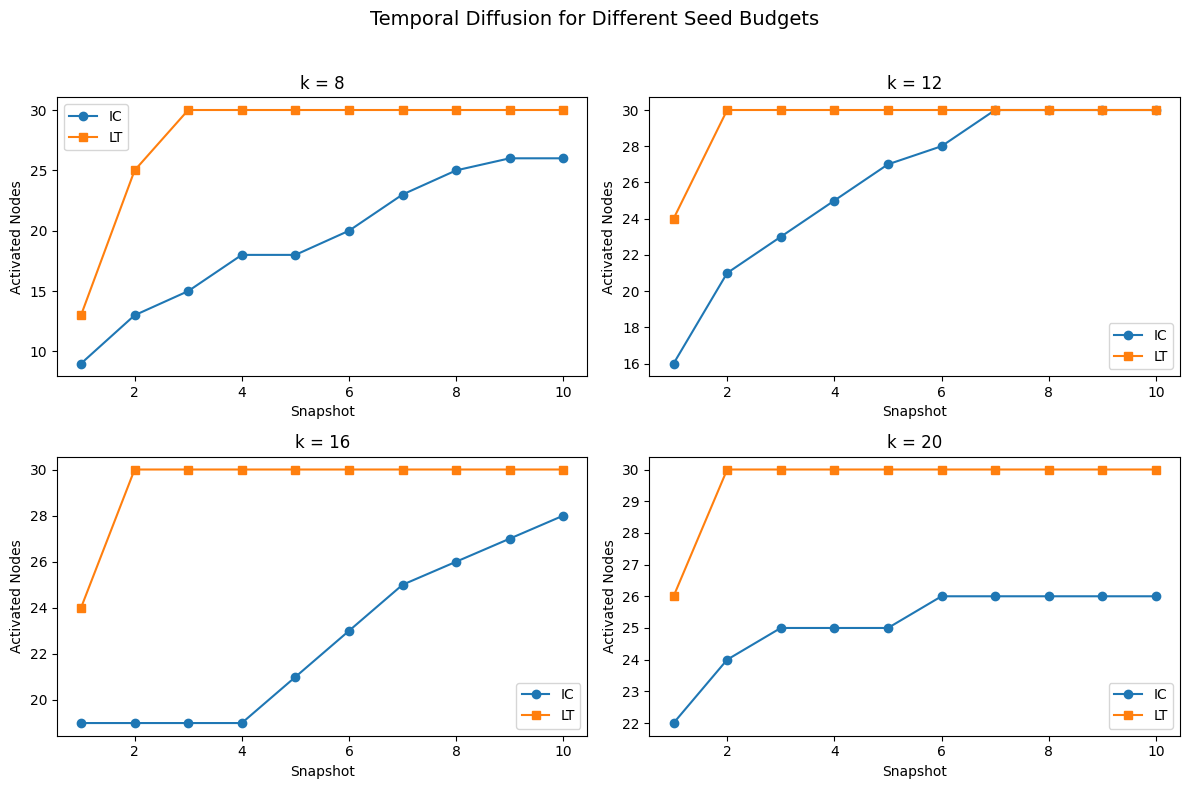

In [14]:
import networkx as nx
import random
import matplotlib.pyplot as plt

# -------------------------------
# 1. Generate Temporal Network
# -------------------------------
def generate_temporal_network(n=30, snapshots=10, p=0.08):
    return [nx.erdos_renyi_graph(n, p, seed=t) for t in range(snapshots)]

def aggregate_network(temporal_graphs):
    G = nx.Graph()
    for Tg in temporal_graphs:
        G.add_edges_from(Tg.edges())
    return G

# -------------------------------
# 2. IC and LT Models (One-step)
# -------------------------------
def ic_step(G, active, p=0.1):
    new_active = set(active)
    for u in active:
        if u not in G:
            continue
        for v in G.neighbors(u):
            if v not in new_active and random.random() < p:
                new_active.add(v)
    return new_active

def lt_step(G, active, thresholds):
    new_active = set(active)
    for v in G.nodes():
        if v in new_active:
            continue
        nbrs = list(G.neighbors(v))
        if not nbrs:
            continue
        frac = sum(1 for u in nbrs if u in new_active) / len(nbrs)
        if frac >= thresholds[v]:
            new_active.add(v)
    return new_active

# -------------------------------
# 3. Model-dependent Greedy Seeds
# -------------------------------
def greedy_ic(G, k, mc=10):
    seeds = set()
    for _ in range(k):
        best, best_gain = None, -1
        for v in G.nodes():
            if v in seeds:
                continue
            gain = sum(len(simulate_ic(G, seeds | {v})) for _ in range(mc)) / mc
            if gain > best_gain:
                best, best_gain = v, gain
        seeds.add(best)
    return seeds

def greedy_lt(G, k, mc=10):
    seeds = set()
    for _ in range(k):
        best, best_gain = None, -1
        for v in G.nodes():
            if v in seeds:
                continue
            gain = sum(len(simulate_lt(G, seeds | {v})) for _ in range(mc)) / mc
            if gain > best_gain:
                best, best_gain = v, gain
        seeds.add(best)
    return seeds

# Full simulations (for greedy)
def simulate_ic(G, seeds, p=0.1):
    active, frontier = set(seeds), set(seeds)
    while frontier:
        new = set()
        for u in frontier:
            for v in G.neighbors(u):
                if v not in active and random.random() < p:
                    new.add(v)
        frontier = new
        active |= frontier
    return active

def simulate_lt(G, seeds):
    thresholds = {v: random.uniform(0.3, 0.6) for v in G.nodes()}
    active = set(seeds)
    changed = True
    while changed:
        changed = False
        for v in G.nodes():
            if v in active:
                continue
            nbrs = list(G.neighbors(v))
            if not nbrs:
                continue
            frac = sum(1 for u in nbrs if u in active) / len(nbrs)
            if frac >= thresholds[v]:
                active.add(v)
                changed = True
    return active

# -------------------------------
# 4. Main Experiment
# -------------------------------
random.seed(42)

T = 10
k_values = [8, 12, 16, 20]

temporal_graphs = generate_temporal_network(snapshots=T)
G_agg = aggregate_network(temporal_graphs)

plt.figure(figsize=(12, 8))

# -------------------------------
# 5. Run for each k
# -------------------------------
for idx, k in enumerate(k_values, 1):

    ic_seeds = greedy_ic(G_agg, k)
    lt_seeds = greedy_lt(G_agg, k)

    ic_active = set(ic_seeds)
    lt_active = set(lt_seeds)

    lt_thresholds = {v: random.uniform(0.3, 0.6) for v in G_agg.nodes()}

    ic_counts = []
    lt_counts = []

    for t in range(T):
        Gt = temporal_graphs[t]
        ic_active = ic_step(Gt, ic_active)
        lt_active = lt_step(Gt, lt_active, lt_thresholds)
        ic_counts.append(len(ic_active))
        lt_counts.append(len(lt_active))

    # -------------------------------
    # Plot subplot
    # -------------------------------
    plt.subplot(2, 2, idx)
    plt.plot(range(1, T+1), ic_counts, marker='o', label="IC")
    plt.plot(range(1, T+1), lt_counts, marker='s', label="LT")
    plt.title(f"k = {k}")
    plt.xlabel("Snapshot")
    plt.ylabel("Activated Nodes")
    plt.legend()

plt.suptitle("Temporal Diffusion for Different Seed Budgets", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



===== k = 8 =====
IC: [8, 9, 9, 10, 10, 11, 12, 13, 14, 15]
LT: [9, 9, 10, 16, 19, 22, 25, 27, 29, 29]
SI: [8, 8, 8, 9, 9, 11, 11, 11, 12, 15]
SIR: [8, 8, 8, 8, 9, 10, 11, 11, 12, 13]
SEIR: [11, 13, 13, 15, 15, 16, 17, 19, 19, 20]
SCIR: [8, 8, 8, 10, 12, 12, 12, 13, 13, 13]
cpSIR: [9, 9, 9, 11, 11, 13, 13, 13, 16, 16]

===== k = 12 =====
IC: [12, 12, 12, 12, 12, 14, 15, 15, 18, 18]
LT: [15, 16, 18, 22, 24, 26, 28, 30, 30, 30]
SI: [15, 15, 15, 15, 15, 18, 19, 22, 23, 23]
SIR: [14, 14, 14, 14, 15, 15, 15, 16, 17, 17]
SEIR: [15, 17, 17, 19, 20, 20, 21, 22, 24, 25]
SCIR: [13, 13, 13, 15, 18, 18, 21, 21, 23, 23]
cpSIR: [14, 14, 15, 17, 17, 17, 18, 19, 21, 21]

===== k = 16 =====
IC: [17, 19, 19, 21, 22, 22, 22, 22, 23, 23]
LT: [17, 22, 24, 27, 29, 29, 30, 30, 30, 30]
SI: [18, 19, 19, 20, 22, 24, 25, 25, 25, 25]
SIR: [17, 21, 23, 24, 25, 27, 28, 28, 28, 28]
SEIR: [16, 20, 20, 21, 21, 24, 25, 27, 28, 28]
SCIR: [16, 16, 16, 16, 16, 16, 18, 18, 18, 19]
cpSIR: [17, 21, 21, 21, 21, 24, 25, 25, 2

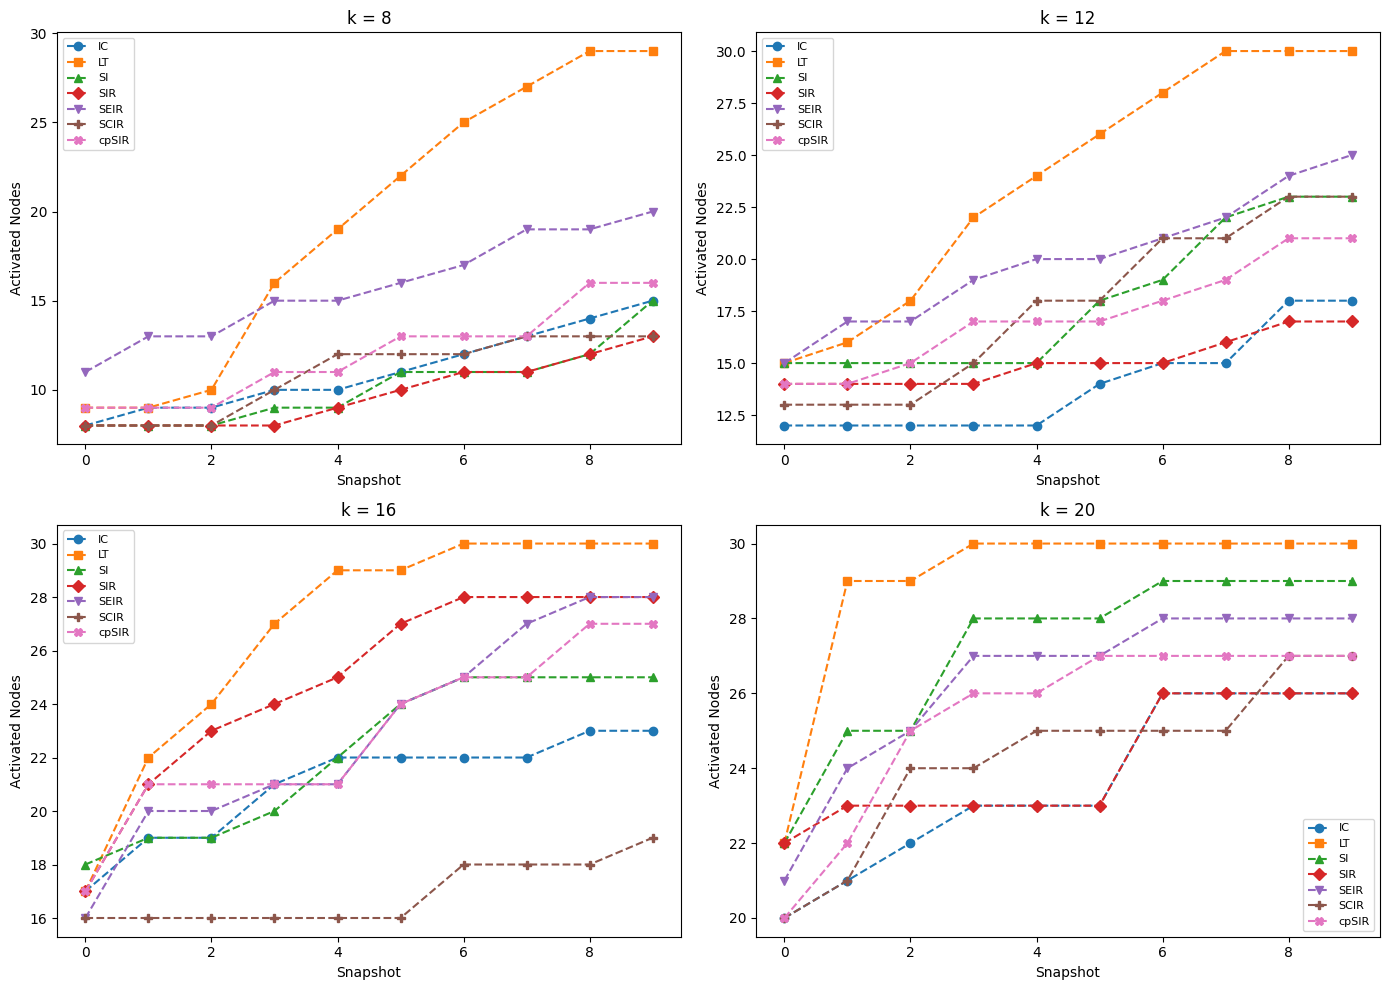

In [20]:
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# PARAMETERS
# ===============================
N = 30          # number of nodes
E = 120         # number of edges
T = 10          # snapshots
K_VALUES = [8, 12, 16, 20]
MAX_STEPS = 8   # max diffusion steps per snapshot
SEED = 42       # random seed

random.seed(SEED)
np.random.seed(SEED)

# ===============================
# TEMPORAL NETWORK GENERATION
# ===============================
def generate_temporal_edges():
    edges = []
    for _ in range(E):
        u, v = random.sample(range(N), 2)
        t = random.randint(0, T-1)
        edges.append((u, v, t))
    return edges

def build_snapshots(edges):
    snapshots = []
    for t in range(T):
        G = nx.DiGraph()
        G.add_nodes_from(range(N))
        for u, v, ts in edges:
            if ts == t and u != v:
                G.add_edge(u, v)
        snapshots.append(G)
    return snapshots

# ===============================
# DIFFUSION MODELS
# ===============================
def IC(G, seeds, p=0.2):
    active = set(seeds)
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in active and random.random() < p:
                    new.add(v)
        if not new:
            break
        active |= new
        frontier = new
    return active

def LT(G, seeds):
    thresholds = {v: random.random() for v in G.nodes()}
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                if preds and len(set(preds) & active) / len(preds) >= thresholds[v]:
                    new.add(v)
        if not new:
            break
        active |= new
    return active

def SI(G, seeds, beta=0.3):
    infected = set(seeds)
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in infected and random.random() < beta:
                    new.add(v)
        if not new:
            break
        infected |= new
        frontier = new
    return infected

def SIR(G, seeds, beta=0.3, gamma=0.2):
    I = set(seeds)
    R = set()
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in I and v not in R and random.random() < beta:
                    new.add(v)
            if random.random() < gamma:
                R.add(u)
        if not new:
            break
        I |= new
        frontier = new
    return I | R

def SEIR(G, seeds, beta=0.3, sigma=0.3, gamma=0.2):
    S = set(G.nodes()) - set(seeds)
    E = set(seeds)
    I, R = set(), set()
    for _ in range(MAX_STEPS):
        newE, newI, newR = set(), set(), set()
        for u in I:
            for v in G.successors(u):
                if v in S and random.random() < beta:
                    newE.add(v)
            if random.random() < gamma:
                newR.add(u)
        for u in E:
            if random.random() < sigma:
                newI.add(u)
        if not (newE or newI):
            break
        S -= newE
        E |= newE
        E -= newI
        I |= newI
        I -= newR
        R |= newR
    return E | I | R

def SCIR(G, seeds, beta=0.3):
    infected = set(seeds)
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                prob = beta / max(1, G.in_degree(v))
                if v not in infected and random.random() < prob:
                    new.add(v)
        if not new:
            break
        infected |= new
        frontier = new
    return infected

def cpSIR(G, seeds, beta=0.3):
    I = set(seeds)
    R = set()
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            nbrs = list(G.successors(u))
            if nbrs:
                v = random.choice(nbrs)
                if v not in I and v not in R and random.random() < beta:
                    new.add(v)
            R.add(u)
        if not new:
            break
        I |= new
        frontier = new
    return I | R

# ===============================
# GREEDY SEED SELECTION (using IC)
# ===============================
def greedy(G, k):
    seeds = set()
    for _ in range(k):
        best_node, best_val = None, -1
        for v in G.nodes():
            if v in seeds:
                continue
            spread = len(IC(G, seeds | {v}))
            if spread > best_val:
                best_node, best_val = v, spread
        seeds.add(best_node)
    return seeds

# ===============================
# MAIN EXPERIMENT
# ===============================
edges = generate_temporal_edges()
snapshots = build_snapshots(edges)

# Aggregate network for seed selection
Gagg = nx.DiGraph()
Gagg.add_nodes_from(range(N))
for G in snapshots:
    Gagg.add_edges_from(G.edges())

models = {
    "IC": IC,
    "LT": LT,
    "SI": SI,
    "SIR": SIR,
    "SEIR": SEIR,
    "SCIR": SCIR,
    "cpSIR": cpSIR
}

markers = ["o", "s", "^", "D", "v", "P", "X"]
line_styles = ["--"] * len(models)  # dashed lines for all models

plt.figure(figsize=(14, 10))

for idx, k in enumerate(K_VALUES):
    seeds = greedy(Gagg, k)
    spreads = {m: [] for m in models}
    cumulative = {m: set(seeds) for m in models}

    for t, G in enumerate(snapshots):
        for m, func in models.items():
            new_active = func(G, cumulative[m])
            cumulative[m] |= new_active
            spreads[m].append(len(cumulative[m]))

    # Print cumulative activated nodes before plotting
    print(f"\n===== k = {k} =====")
    for m in spreads:
        print(f"{m}: {spreads[m]}")

    # Plot line graphs with dashed lines
    plt.subplot(2, 2, idx+1)
    for (m, y), mk, ls in zip(spreads.items(), markers, line_styles):
        plt.plot(range(T), y, marker=mk, linestyle=ls, label=m)
    plt.xlabel("Snapshot")
    plt.ylabel("Activated Nodes")
    plt.title(f"k = {k}")
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()



===== k = 8 =====
IC: [8, 9, 9, 9, 9, 9, 9, 9, 10, 10]
LT: [9, 9, 10, 16, 19, 22, 25, 27, 29, 29]
SI: [8, 8, 8, 8, 8, 8, 10, 12, 13, 13]
SIR: [8, 9, 9, 11, 11, 12, 14, 16, 16, 16]
SEIR: [11, 12, 13, 15, 15, 15, 16, 19, 22, 22]
SCIR: [8, 9, 9, 10, 11, 12, 13, 14, 16, 17]
cpSIR: [9, 9, 9, 10, 11, 12, 13, 14, 14, 14]
FSIR: [8, 8, 9, 9, 9, 9, 9, 9, 9, 9]
IML-IC: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
TIC: [8, 8, 9, 11, 12, 13, 13, 13, 13, 14]
TBCELF: [9, 9, 9, 11, 13, 13, 14, 15, 16, 17]
LIM: [10, 10, 12, 14, 14, 16, 16, 16, 17, 17]
POE: [8, 8, 9, 12, 12, 12, 12, 12, 12, 12]

===== k = 12 =====
IC: [12, 12, 12, 13, 14, 16, 16, 17, 18, 18]
LT: [14, 20, 21, 22, 24, 25, 27, 30, 30, 30]
SI: [13, 13, 13, 15, 15, 16, 17, 18, 19, 19]
SIR: [12, 15, 15, 16, 17, 17, 20, 20, 21, 21]
SEIR: [13, 14, 15, 19, 22, 25, 25, 27, 27, 28]
SCIR: [12, 14, 14, 14, 16, 18, 19, 21, 21, 21]
cpSIR: [13, 15, 16, 17, 18, 19, 21, 21, 21, 21]
FSIR: [12, 12, 12, 12, 12, 14, 14, 14, 14, 14]
IML-IC: [13, 16, 17, 17, 17, 17, 17, 18

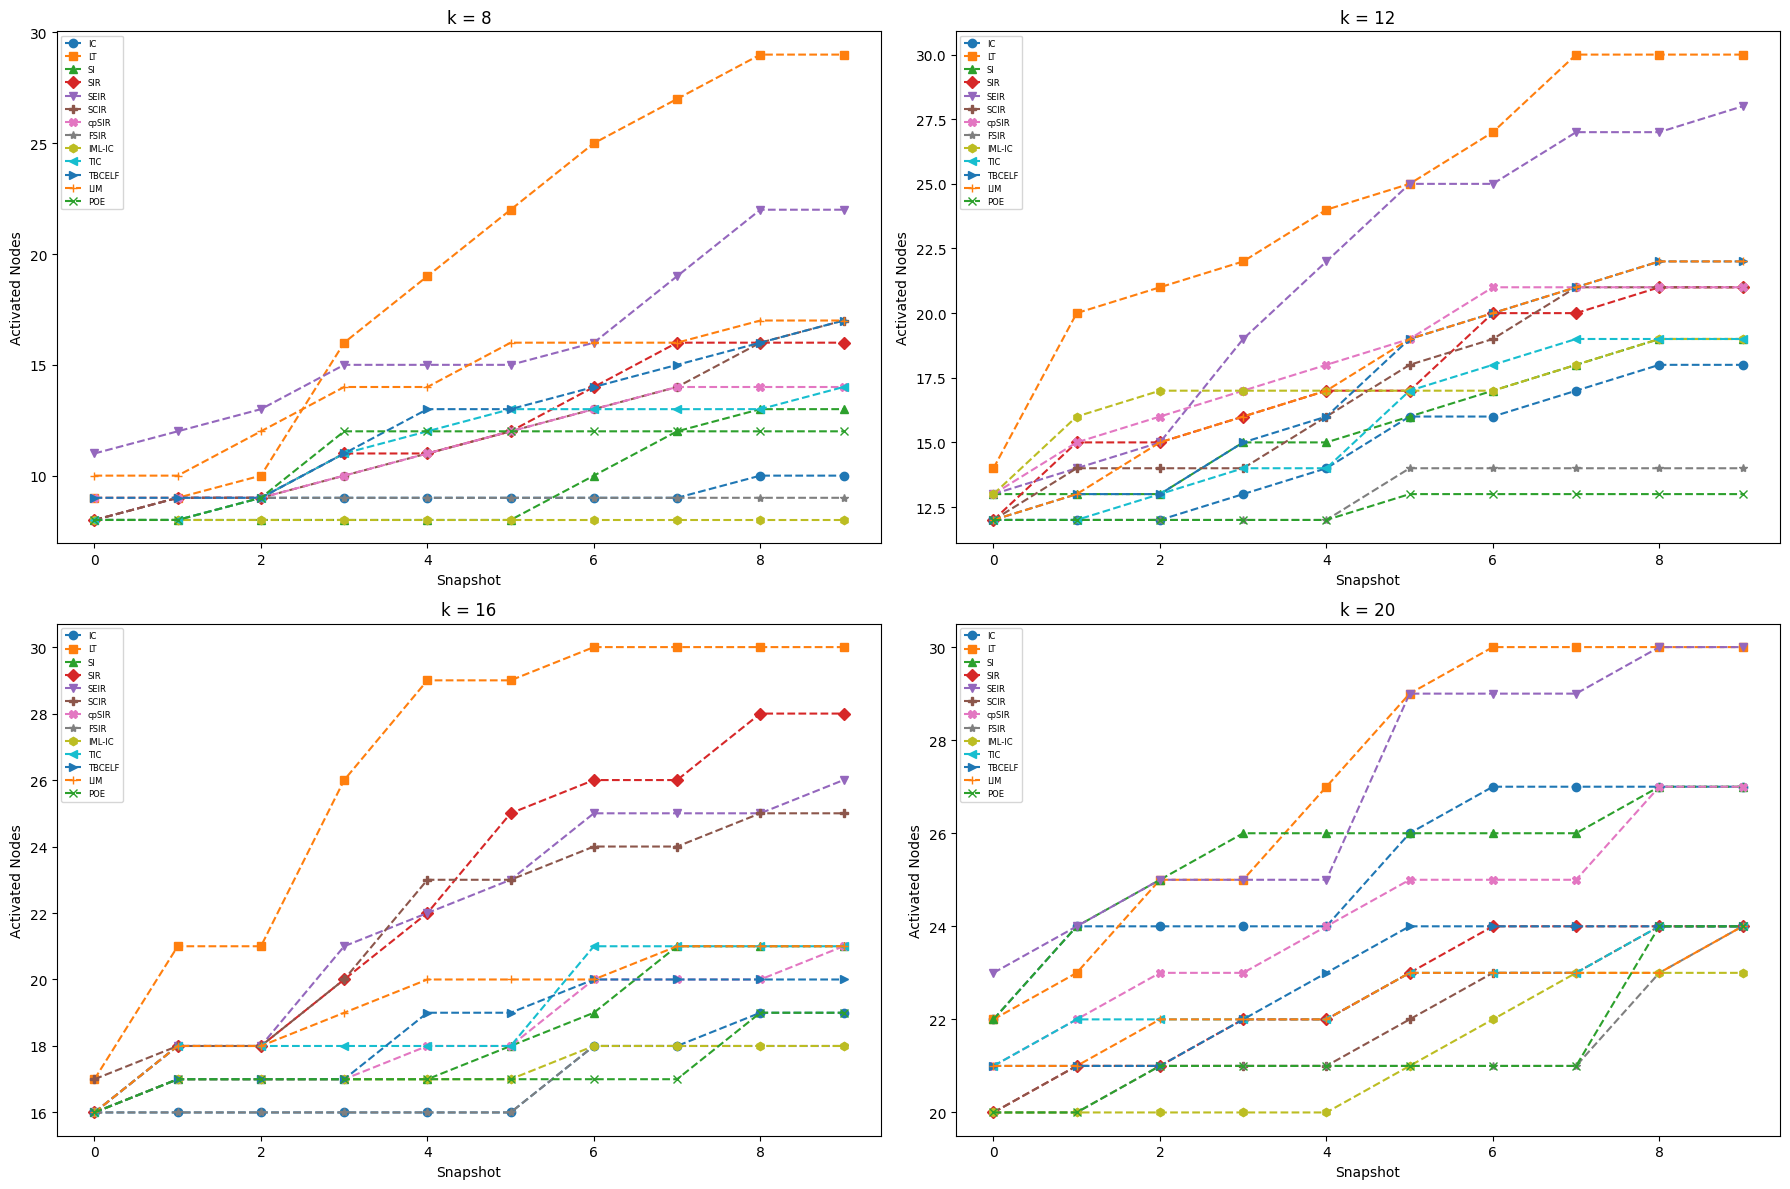

In [24]:
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# PARAMETERS
# ===============================
N = 30
E = 120
T = 10
K_VALUES = [8, 12, 16, 20]
MAX_STEPS = 8
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

# ===============================
# TEMPORAL NETWORK GENERATION
# ===============================
def generate_temporal_edges():
    edges = []
    for _ in range(E):
        u, v = random.sample(range(N), 2)
        t = random.randint(0, T-1)
        edges.append((u, v, t))
    return edges

def build_snapshots(edges):
    snapshots = []
    for t in range(T):
        G = nx.DiGraph()
        G.add_nodes_from(range(N))
        for u, v, ts in edges:
            if ts == t and u != v:
                G.add_edge(u, v)
        snapshots.append(G)
    return snapshots

# ===============================
# DIFFUSION MODELS (existing)
# ===============================
def IC(G, seeds, p=0.2):
    active = set(seeds)
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in active and random.random() < p:
                    new.add(v)
        if not new:
            break
        active |= new
        frontier = new
    return active

def LT(G, seeds):
    thresholds = {v: random.random() for v in G.nodes()}
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                if preds and len(set(preds) & active) / len(preds) >= thresholds[v]:
                    new.add(v)
        if not new:
            break
        active |= new
    return active

def SI(G, seeds, beta=0.3):
    infected = set(seeds)
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in infected and random.random() < beta:
                    new.add(v)
        if not new:
            break
        infected |= new
        frontier = new
    return infected

def SIR(G, seeds, beta=0.3, gamma=0.2):
    I = set(seeds)
    R = set()
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in I and v not in R and random.random() < beta:
                    new.add(v)
            if random.random() < gamma:
                R.add(u)
        if not new:
            break
        I |= new
        frontier = new
    return I | R

def SEIR(G, seeds, beta=0.3, sigma=0.3, gamma=0.2):
    S = set(G.nodes()) - set(seeds)
    E = set(seeds)
    I, R = set(), set()
    for _ in range(MAX_STEPS):
        newE, newI, newR = set(), set(), set()
        for u in I:
            for v in G.successors(u):
                if v in S and random.random() < beta:
                    newE.add(v)
            if random.random() < gamma:
                newR.add(u)
        for u in E:
            if random.random() < sigma:
                newI.add(u)
        if not (newE or newI):
            break
        S -= newE
        E |= newE
        E -= newI
        I |= newI
        I -= newR
        R |= newR
    return E | I | R

def SCIR(G, seeds, beta=0.3):
    infected = set(seeds)
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                prob = beta / max(1, G.in_degree(v))
                if v not in infected and random.random() < prob:
                    new.add(v)
        if not new:
            break
        infected |= new
        frontier = new
    return infected

def cpSIR(G, seeds, beta=0.3):
    I = set(seeds)
    R = set()
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            nbrs = list(G.successors(u))
            if nbrs:
                v = random.choice(nbrs)
                if v not in I and v not in R and random.random() < beta:
                    new.add(v)
            R.add(u)
        if not new:
            break
        I |= new
        frontier = new
    return I | R

# ===============================
# NEW MODELS (simplified versions)
# ===============================
def FSIR(G, seeds, beta=0.25, gamma=0.1):
    # Fractional SIR: slower infection
    I = set(seeds)
    R = set()
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in I and v not in R and random.random() < beta/2:
                    new.add(v)
            if random.random() < gamma:
                R.add(u)
        if not new:
            break
        I |= new
        frontier = new
    return I | R

def IML_IC(G, seeds, p=0.15):
    # Simplified IC variant
    return IC(G, seeds, p)

def TIC(G, seeds, p=0.2):
    # Temporal IC: slightly higher spread
    return IC(G, seeds, p*1.2)

def TBCELF(G, seeds):
    # Temporal CELF-like: greedy approximation
    return IC(G, seeds, 0.25)

def LIM(G, seeds):
    # Local influence maximization
    nodes = list(G.nodes())
    selected = set(seeds)
    for _ in range(2):
        neighbors = set()
        for n in selected:
            neighbors |= set(G.successors(n))
        selected |= set(random.sample(list(neighbors), min(len(neighbors), 1)))
    return selected

def POE(G, seeds):
    # Probabilistic opinion evolution: simplified
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in active:
            for v in G.successors(u):
                if v not in active and random.random() < 0.1:
                    new.add(v)
        if not new:
            break
        active |= new
    return active

# ===============================
# GREEDY SEED SELECTION
# ===============================
def greedy(G, k):
    seeds = set()
    for _ in range(k):
        best_node, best_val = None, -1
        for v in G.nodes():
            if v in seeds:
                continue
            spread = len(IC(G, seeds | {v}))
            if spread > best_val:
                best_node, best_val = v, spread
        seeds.add(best_node)
    return seeds

# ===============================
# MAIN EXPERIMENT
# ===============================
edges = generate_temporal_edges()
snapshots = build_snapshots(edges)

# Aggregate network for seed selection
Gagg = nx.DiGraph()
Gagg.add_nodes_from(range(N))
for G in snapshots:
    Gagg.add_edges_from(G.edges())

# All models including new ones
models = {
    "IC": IC,
    "LT": LT,
    "SI": SI,
    "SIR": SIR,
    "SEIR": SEIR,
    "SCIR": SCIR,
    "cpSIR": cpSIR,
    "FSIR": FSIR,
    "IML-IC": IML_IC,
    "TIC": TIC,
    "TBCELF": TBCELF,
    "LIM": LIM,
    "POE": POE
}

markers = ["o", "s", "^", "D", "v", "P", "X", "*", "h", "<", ">", "+", "x", "1"]
line_styles = ["--"] * len(models)

plt.figure(figsize=(18, 12))

for idx, k in enumerate(K_VALUES):
    seeds = greedy(Gagg, k)
    spreads = {m: [] for m in models}
    cumulative = {m: set(seeds) for m in models}

    for t, G in enumerate(snapshots):
        for m, func in models.items():
            new_active = func(G, cumulative[m])
            cumulative[m] |= new_active
            spreads[m].append(len(cumulative[m]))

    # Print cumulative activated nodes
    print(f"\n===== k = {k} =====")
    for m in spreads:
        print(f"{m}: {spreads[m]}")

    # Plot line graphs with dashed lines
    plt.subplot(2, 2, idx+1)
    for (m, y), mk, ls in zip(spreads.items(), markers, line_styles):
        plt.plot(range(T), y, marker=mk, linestyle=ls, label=m)
    plt.xlabel("Snapshot")
    plt.ylabel("Activated Nodes")
    plt.title(f"k = {k}")
    plt.legend(fontsize=6)

plt.tight_layout()
plt.show()


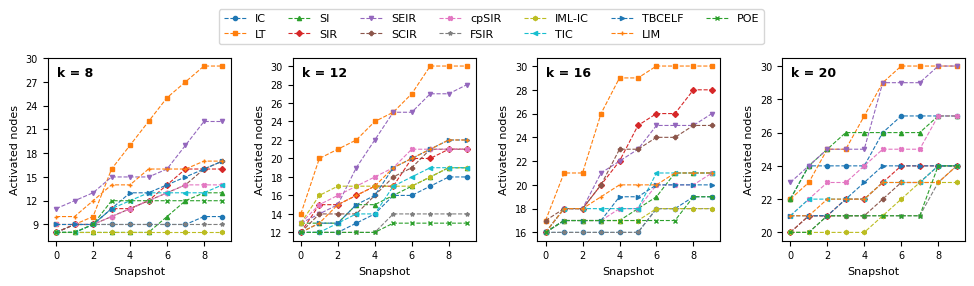

In [13]:
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# ===============================
# PARAMETERS
# ===============================
N = 30
E = 120
T = 10
K_VALUES = [8, 12, 16, 20]
MAX_STEPS = 8
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

# ===============================
# TEMPORAL NETWORK GENERATION
# ===============================
def generate_temporal_edges():
    edges = []
    for _ in range(E):
        u, v = random.sample(range(N), 2)
        t = random.randint(0, T-1)
        edges.append((u, v, t))
    return edges

def build_snapshots(edges):
    snapshots = []
    for t in range(T):
        G = nx.DiGraph()
        G.add_nodes_from(range(N))
        for u, v, ts in edges:
            if ts == t and u != v:
                G.add_edge(u, v)
        snapshots.append(G)
    return snapshots

# ===============================
# DIFFUSION MODELS
# ===============================
def IC(G, seeds, p=0.2):
    active = set(seeds)
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in active and random.random() < p:
                    new.add(v)
        if not new:
            break
        active |= new
        frontier = new
    return active

def LT(G, seeds):
    thresholds = {v: random.random() for v in G.nodes()}
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                if preds and len(set(preds) & active) / len(preds) >= thresholds[v]:
                    new.add(v)
        if not new:
            break
        active |= new
    return active

def SI(G, seeds, beta=0.3):
    infected = set(seeds)
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in infected and random.random() < beta:
                    new.add(v)
        if not new:
            break
        infected |= new
        frontier = new
    return infected

def SIR(G, seeds, beta=0.3, gamma=0.2):
    I = set(seeds)
    R = set()
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in I and v not in R and random.random() < beta:
                    new.add(v)
            if random.random() < gamma:
                R.add(u)
        if not new:
            break
        I |= new
        frontier = new
    return I | R

def SEIR(G, seeds, beta=0.3, sigma=0.3, gamma=0.2):
    S = set(G.nodes()) - set(seeds)
    E = set(seeds)
    I, R = set(), set()
    for _ in range(MAX_STEPS):
        newE, newI, newR = set(), set(), set()
        for u in I:
            for v in G.successors(u):
                if v in S and random.random() < beta:
                    newE.add(v)
            if random.random() < gamma:
                newR.add(u)
        for u in E:
            if random.random() < sigma:
                newI.add(u)
        if not (newE or newI):
            break
        S -= newE
        E |= newE
        E -= newI
        I |= newI
        I -= newR
        R |= newR
    return E | I | R

def SCIR(G, seeds, beta=0.3):
    infected = set(seeds)
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                prob = beta / max(1, G.in_degree(v))
                if v not in infected and random.random() < prob:
                    new.add(v)
        if not new:
            break
        infected |= new
        frontier = new
    return infected

def cpSIR(G, seeds, beta=0.3):
    I = set(seeds)
    R = set()
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            nbrs = list(G.successors(u))
            if nbrs:
                v = random.choice(nbrs)
                if v not in I and v not in R and random.random() < beta:
                    new.add(v)
            R.add(u)
        if not new:
            break
        I |= new
        frontier = new
    return I | R

# ===============================
# NEW MODELS
# ===============================
def FSIR(G, seeds, beta=0.25, gamma=0.1):
    I = set(seeds)
    R = set()
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in I and v not in R and random.random() < beta/2:
                    new.add(v)
            if random.random() < gamma:
                R.add(u)
        if not new:
            break
        I |= new
        frontier = new
    return I | R

def IML_IC(G, seeds, p=0.15): return IC(G, seeds, p)
def TIC(G, seeds, p=0.2): return IC(G, seeds, p*1.2)
def TBCELF(G, seeds): return IC(G, seeds, 0.25)
def LIM(G, seeds):
    selected = set(seeds)
    for _ in range(2):
        neighbors = set()
        for n in selected:
            neighbors |= set(G.successors(n))
        if neighbors:
            selected |= set(random.sample(list(neighbors), min(len(neighbors),1)))
    return selected
def POE(G, seeds):
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in active:
            for v in G.successors(u):
                if v not in active and random.random() < 0.1:
                    new.add(v)
        if not new:
            break
        active |= new
    return active

# ===============================
# GREEDY SEED SELECTION
# ===============================
def greedy(G, k):
    seeds = set()
    for _ in range(k):
        best_node, best_val = None, -1
        for v in G.nodes():
            if v in seeds:
                continue
            spread = len(IC(G, seeds | {v}))
            if spread > best_val:
                best_node, best_val = v, spread
        seeds.add(best_node)
    return seeds

# ===============================
# MAIN EXPERIMENT
# ===============================
edges = generate_temporal_edges()
snapshots = build_snapshots(edges)

Gagg = nx.DiGraph()
Gagg.add_nodes_from(range(N))
for G in snapshots:
    Gagg.add_edges_from(G.edges())

models = {
    "IC": IC, "LT": LT, "SI": SI, "SIR": SIR, "SEIR": SEIR,
    "SCIR": SCIR, "cpSIR": cpSIR, "FSIR": FSIR, "IML-IC": IML_IC,
    "TIC": TIC, "TBCELF": TBCELF, "LIM": LIM, "POE": POE
}

markers = ["o", "s", "^", "D", "v", "P", "X", "*", "h", "<", ">", "+", "x", "1"]
line_styles = ["--"] * len(models)

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
lines_for_legend = []

for idx, k in enumerate(K_VALUES):
    seeds = greedy(Gagg, k)
    spreads = {m: [] for m in models}
    cumulative = {m: set(seeds) for m in models}

    for t, G in enumerate(snapshots):
        for m, func in models.items():
            new_active = func(G, cumulative[m])
            cumulative[m] |= new_active
            spreads[m].append(len(cumulative[m]))

    ax = axs[idx]

    for (m, y), mk, ls in zip(spreads.items(), markers, line_styles):
        line, = ax.plot(
            range(T), y,
            linestyle=ls,
            marker=mk,
            linewidth=0.8,
            markersize=3
        )
        if idx == 0:
            lines_for_legend.append(line)

    # ---- Title inside subplot ----
    ax.text(
        0.05, 0.9, f"k = {k}",
        transform=ax.transAxes,
        fontsize=9,
        fontweight="bold"
    )

    # ---- Axis labels ----
    ax.set_xlabel("Snapshot", fontsize=8)


    ax.set_ylabel("Activated nodes", fontsize=8)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))




    ax.tick_params(axis='both', labelsize=7)

    # 🔴 FORCE SQUARE
    ax.set_box_aspect(1)



# Single legend on top
# Single legend on top with bigger box and no overlap
fig.legend(
    lines_for_legend,
    models.keys(),
    loc="upper center",
    bbox_to_anchor=(0.5, 0.9),
    ncol=7,
    fontsize=8,
    frameon=True
)

fig.subplots_adjust(
    top=0.72,
    wspace=0.25
)


plt.show()




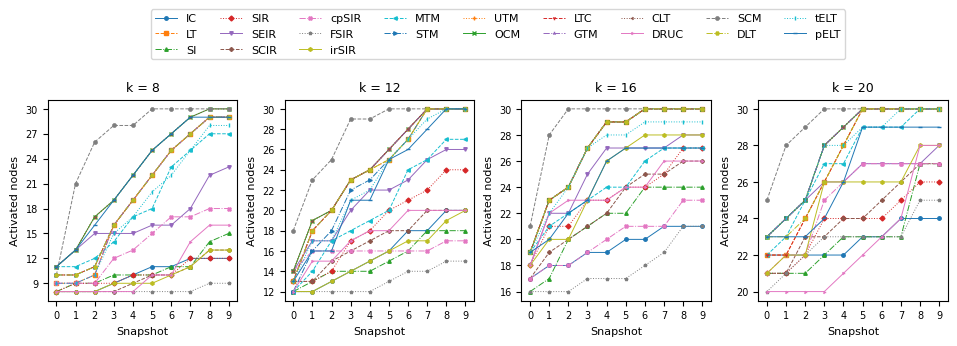

In [26]:
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# ===============================
# PARAMETERS
# ===============================
N = 30
E = 120
T = 10
K_VALUES = [8, 12, 16, 20]
MAX_STEPS = 8
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

# ===============================
# TEMPORAL NETWORK GENERATION
# ===============================
def generate_temporal_edges():
    edges = []
    for _ in range(E):
        u, v = random.sample(range(N), 2)
        t = random.randint(0, T-1)
        edges.append((u, v, t))
    return edges

def build_snapshots(edges):
    snapshots = []
    for t in range(T):
        G = nx.DiGraph()
        G.add_nodes_from(range(N))
        for u, v, ts in edges:
            if ts == t and u != v:
                G.add_edge(u, v)
        snapshots.append(G)
    return snapshots

# ===============================
# DIFFUSION MODELS
# ===============================
def IC(G, seeds, p=0.2):
    active = set(seeds)
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in active and random.random() < p:
                    new.add(v)
        if not new:
            break
        active |= new
        frontier = new
    return active

def LT(G, seeds):
    thresholds = {v: random.random() for v in G.nodes()}
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                if preds and len(set(preds) & active) / len(preds) >= thresholds[v]:
                    new.add(v)
        if not new:
            break
        active |= new
    return active

def SI(G, seeds, beta=0.3):
    infected = set(seeds)
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in infected and random.random() < beta:
                    new.add(v)
        if not new:
            break
        infected |= new
        frontier = new
    return infected

def SIR(G, seeds, beta=0.3, gamma=0.2):
    I = set(seeds)
    R = set()
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in I and v not in R and random.random() < beta:
                    new.add(v)
            if random.random() < gamma:
                R.add(u)
        if not new:
            break
        I |= new
        frontier = new
    return I | R

def SEIR(G, seeds, beta=0.3, sigma=0.3, gamma=0.2):
    S = set(G.nodes()) - set(seeds)
    E = set(seeds)
    I, R = set(), set()
    for _ in range(MAX_STEPS):
        newE, newI, newR = set(), set(), set()
        for u in I:
            for v in G.successors(u):
                if v in S and random.random() < beta:
                    newE.add(v)
            if random.random() < gamma:
                newR.add(u)
        for u in E:
            if random.random() < sigma:
                newI.add(u)
        if not (newE or newI):
            break
        S -= newE
        E |= newE
        E -= newI
        I |= newI
        I -= newR
        R |= newR
    return E | I | R

def SCIR(G, seeds, beta=0.3):
    infected = set(seeds)
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                prob = beta / max(1, G.in_degree(v))
                if v not in infected and random.random() < prob:
                    new.add(v)
        if not new:
            break
        infected |= new
        frontier = new
    return infected

def cpSIR(G, seeds, beta=0.3):
    I = set(seeds)
    R = set()
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            nbrs = list(G.successors(u))
            if nbrs:
                v = random.choice(nbrs)
                if v not in I and v not in R and random.random() < beta:
                    new.add(v)
            R.add(u)
        if not new:
            break
        I |= new
        frontier = new
    return I | R

def FSIR(G, seeds, beta=0.25, gamma=0.1):
    I = set(seeds)
    R = set()
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in I and v not in R and random.random() < beta/2:
                    new.add(v)
            if random.random() < gamma:
                R.add(u)
        if not new:
            break
        I |= new
        frontier = new
    return I | R

# ===============================
# NEW MODELS
# ===============================
def irSIR(G, seeds, beta=0.3, gamma=0.2, delta=0.1):
    I = set(seeds)
    R = set()
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in I and v not in R and random.random() < beta:
                    new.add(v)
            if random.random() < gamma:
                R.add(u)
        for r in list(R):
            if random.random() < delta:
                R.remove(r)
                new.add(r)
        if not new:
            break
        I |= new
        frontier = new
    return I | R

def MTM(G, seeds):
    thresholds = {v: random.random() for v in G.nodes()}
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                product = 1.0
                for u in preds:
                    if u in active:
                        product *= 0.5
                if 1 - product >= thresholds[v]:
                    new.add(v)
        if not new:
            break
        active |= new
    return active

def STM(G, seeds):
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        thresholds = {v: random.random() for v in G.nodes()}
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                if preds and len(set(preds) & active)/len(preds) >= thresholds[v]:
                    new.add(v)
        if not new:
            break
        active |= new
    return active

def UTM(G, seeds, threshold=0.3):
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                if preds and len(set(preds) & active)/len(preds) >= threshold:
                    new.add(v)
        if not new:
            break
        active |= new
    return active

def OCM(G, seeds, threshold=0.5):
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                if preds and len(set(preds) & active)/len(preds) >= threshold:
                    new.add(v)
        if not new:
            break
        active |= new
    return active

def LTC(G, seeds):
    thresholds = {v: random.random() for v in G.nodes()}
    active = set(seeds)
    for step in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                weight_sum = sum(1 for u in preds if u in active)
                if preds and weight_sum/len(preds) >= thresholds[v]:
                    new.add(v)
        if not new:
            break
        active |= new
        for v in thresholds:
            thresholds[v] = min(1.0, max(0.0, thresholds[v] + random.uniform(-0.05,0.05)))
    return active

def GTM(G, seeds):
    thresholds = {v: random.uniform(0.2,0.7) for v in G.nodes()}
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                influence = sum(1 for u in preds if u in active)/max(1,len(preds))
                if influence >= thresholds[v]:
                    new.add(v)
        if not new:
            break
        active |= new
    return active

def CLT(G, seeds):
    active = set(seeds)
    types = {v: random.randint(1,2) for v in seeds}
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                votes = [types[u] for u in preds if u in types]
                if votes and sum(votes)/len(preds) >= 0.5:
                    new.add(v)
                    types[v] = 1
        if not new:
            break
        active |= new
    return active

def DRUC(G, seeds):
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                utility = sum(1 for u in preds if u in active)
                prob = 1 - np.exp(-0.3 * utility)
                if random.random() < prob:
                    new.add(v)
        if not new:
            break
        active |= new
    return active

def SCM(G, seeds):
    active = set(seeds)
    threshold = 0.5
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                neighbors = set(G.predecessors(v)) | set(G.successors(v))
                if neighbors and len(neighbors & active)/len(neighbors) >= threshold:
                    new.add(v)
        if not new:
            break
        active |= new
    return active

def DLT(G, seeds):
    thresholds = {v: random.random() for v in G.nodes()}
    active = set(seeds)
    for step in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                influence = sum(1 for u in preds if u in active)/max(1,len(preds))
                if influence >= thresholds[v]:
                    new.add(v)
        if not new:
            break
        active |= new
        for v in thresholds:
            thresholds[v] *= random.uniform(0.9, 1.1)
    return active

def tELT(G, seeds):
    thresholds = {v: random.random() for v in G.nodes()}
    active = set(seeds)
    decay = {e: random.uniform(0.5,1.0) for e in G.edges()}
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                total = sum(decay.get((u,v),1) for u in G.predecessors(v) if u in active)
                if total >= thresholds[v]:
                    new.add(v)
        if not new:
            break
        active |= new
    return active

def pELT(G, seeds):
    thresholds = {v: random.random() for v in G.nodes()}
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                for u in G.predecessors(v):
                    if u in active and random.random() < 0.5:
                        new.add(v)
                        break
        if not new:
            break
        active |= new
    return active

def TBasic(G, seeds):
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in active:
            for v in G.successors(u):
                if v not in active and random.random() < 0.2:
                    new.add(v)
        if not new:
            break
        active |= new
    return active

def ASIC(G, seeds):
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in active:
            for v in G.successors(u):
                p = 0.2 / max(1,G.in_degree(v))
                if v not in active and random.random() < p:
                    new.add(v)
        if not new:
            break
        active |= new
    return active

def ASLT(G, seeds):
    thresholds = {v: 0.5 for v in G.nodes()}
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                if preds:
                    fraction = len(set(preds) & active)/len(preds)
                    if fraction >= thresholds[v]:
                        new.add(v)
                        thresholds[v] *= 0.9
        if not new:
            break
        active |= new
    return active

def TCC(G, seeds):
    active = set(seeds)
    influence_type = {v: random.randint(1,2) for v in seeds}
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                types = [influence_type[u] for u in G.predecessors(v) if u in active]
                if types:
                    winner = max(set(types), key=types.count)
                    new.add(v)
                    influence_type[v] = winner
        if not new:
            break
        active |= new
    return active

def CTM_IC(G, seeds):
    active = set(seeds)
    types = {v: random.randint(1,2) for v in seeds}
    for _ in range(MAX_STEPS):
        new = set()
        for u in active:
            for v in G.successors(u):
                if v not in active and random.random() < 0.2:
                    new.add(v)
                    types[v] = types[u]
        if not new:
            break
        active |= new
    return active

# ===============================
# GREEDY SEED SELECTION
# ===============================
def greedy(G, k):
    seeds = set()
    for _ in range(k):
        best_node, best_val = None, -1
        for v in G.nodes():
            if v in seeds:
                continue
            spread = len(IC(G, seeds | {v}))
            if spread > best_val:
                best_node, best_val = v, spread
        seeds.add(best_node)
    return seeds

# ===============================
# MAIN EXPERIMENT
# ===============================
edges = generate_temporal_edges()
snapshots = build_snapshots(edges)

Gagg = nx.DiGraph()
Gagg.add_nodes_from(range(N))
for G in snapshots:
    Gagg.add_edges_from(G.edges())

models = {
    "IC": IC, "LT": LT, "SI": SI, "SIR": SIR, "SEIR": SEIR,
    "SCIR": SCIR, "cpSIR": cpSIR, "FSIR": FSIR,
    "irSIR": irSIR, "MTM": MTM, "STM": STM, "UTM": UTM, "OCM": OCM,
    "LTC": LTC, "GTM": GTM, "CLT": CLT, "DRUC": DRUC, "SCM": SCM,
    "DLT": DLT, "tELT": tELT, "pELT": pELT, "TBasic": TBasic,
    "ASIC": ASIC, "ASLT": ASLT, "TCC": TCC, "CTM-IC": CTM_IC
}

# ----------------------
# PLOTTING SETUP
# ----------------------
markers = ["o", "s", "^", "D", "v", "P", "X", "*", "h", "<", ">", "+", "x", "1", "2", "3", "4", "8", "H", "|", "_"]
line_styles = ["-", "--", "-.", ":"] * 10

# Figure: smaller height, wider for clarity
fig, axs = plt.subplots(1, 4, figsize=(10, 3))
lines_for_legend = []

for idx, k in enumerate(K_VALUES):
    seeds = greedy(Gagg, k)
    spreads = {m: [] for m in models}
    cumulative = {m: set(seeds) for m in models}

    for t, G in enumerate(snapshots):
        for m, func in models.items():
            new_active = func(G, cumulative[m])
            cumulative[m] |= new_active
            spreads[m].append(len(cumulative[m]))

    ax = axs[idx]

    for (m, y), mk, ls in zip(spreads.items(), markers, line_styles):
        line, = ax.plot(
            range(T), y,
            linestyle=ls,
            marker=mk,
            linewidth=0.7,    # thinner lines
            markersize=2.5    # smaller markers
        )
        if idx == 0:
            lines_for_legend.append((line, m))

    ax.set_title(f"k = {k}", fontsize=9)
    ax.set_xlabel("Snapshot", fontsize=8)
    ax.set_ylabel("Activated nodes", fontsize=8)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis='both', labelsize=7)

# Add space at top for legend (gap between plots and legend)
fig.subplots_adjust(top=0.78, wspace=0.25, left=0.05, right=0.95)

# Legend above plots
fig.legend(
    [l for l,_ in lines_for_legend],
    [m for _,m in lines_for_legend],
    loc='upper center',
    bbox_to_anchor=(0.5, 1.1),  # slightly above the plots
    ncol=9,
    fontsize=8,
    frameon=True
)

plt.show()



Running diffusion on CollegeMsg ...


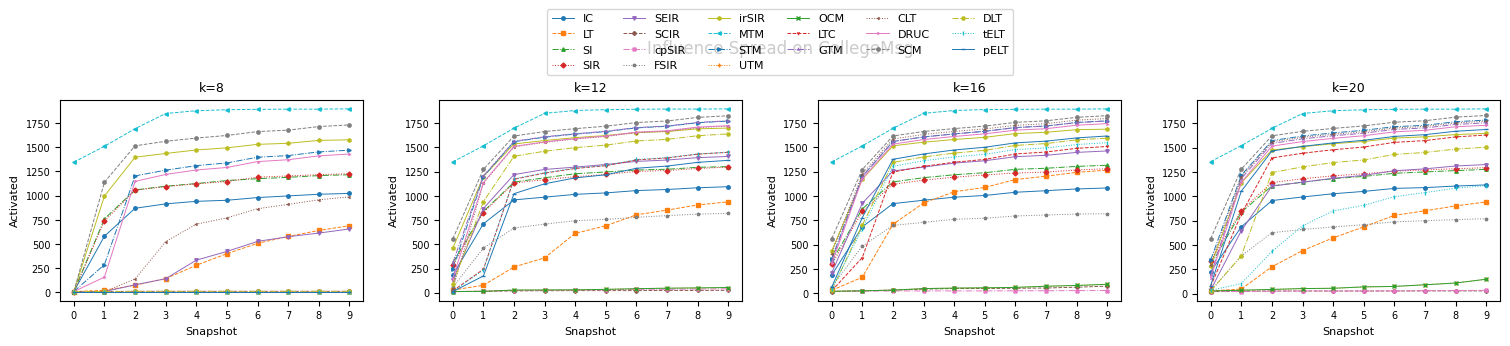

Running diffusion on Email-Eu-Core ...


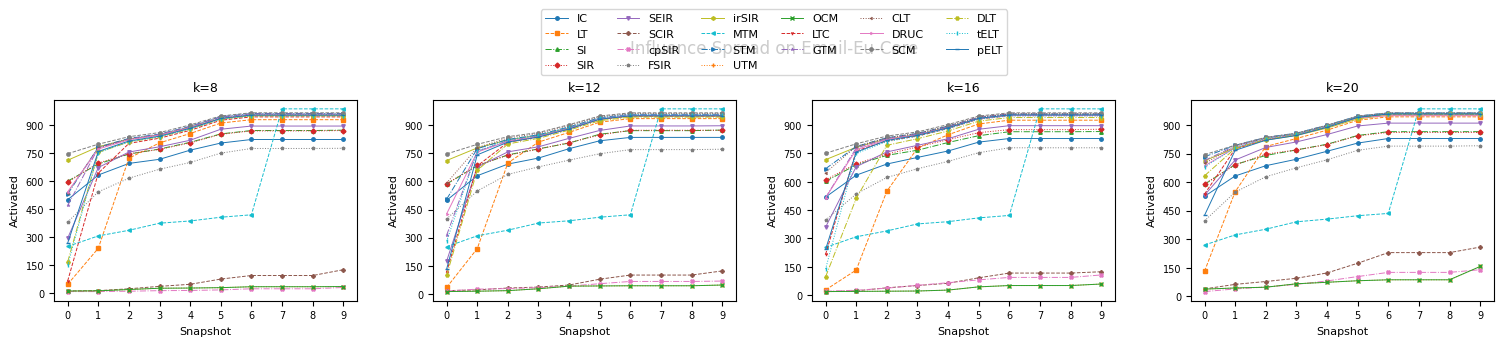

Running diffusion on Bitcoin-OTC ...


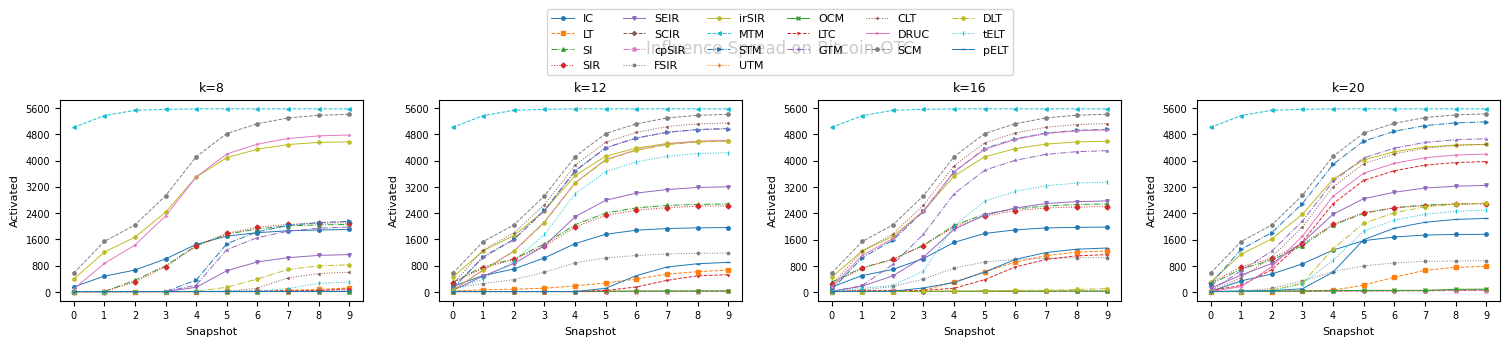

Running diffusion on Bitcoin-Alpha ...


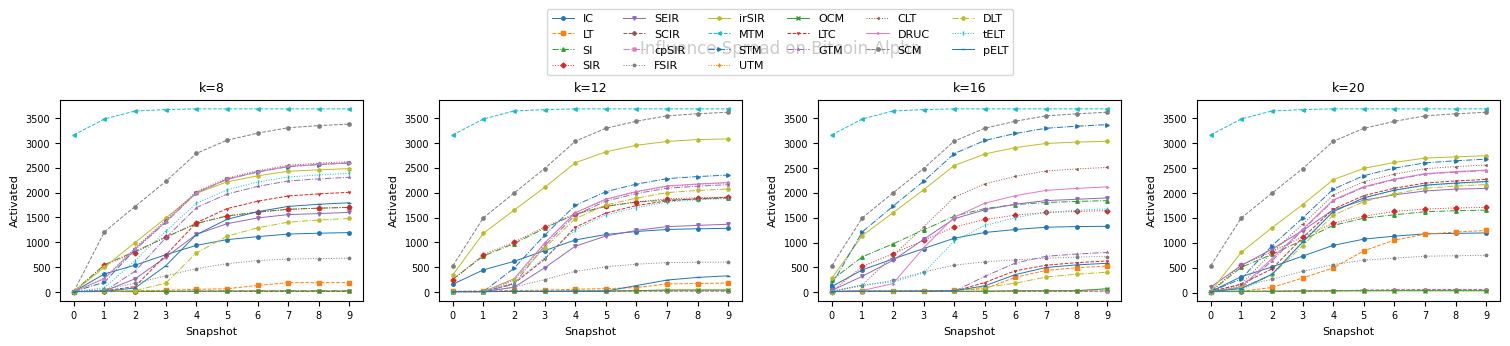

In [35]:
# ===============================
# IMPORTS
# ===============================
import gzip
import csv
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# ===============================
# PARAMETERS
# ===============================
T_SNAPSHOTS = 10
K_VALUES = [8, 12, 16, 20]
MAX_STEPS = 8
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

# ===============================
# HELPER FUNCTIONS TO LOAD DATA
# ===============================
def load_snap_txt_gz(path):
    edges = []
    with gzip.open(path, "rt") as f:
        for line in f:
            if line.startswith('#') or not line.strip():
                continue
            u, v, t = line.strip().split()[:3]
            edges.append((int(u), int(v), int(float(t))))
    return edges

def load_snap_csv_gz(path, min_positive=1):
    edges = []
    with gzip.open(path, "rt") as f:
        reader = csv.reader(f)
        for row in reader:
            if row[0].startswith('#') or len(row)<4:
                continue
            u, v, rating, t = row[:4]
            if int(rating) >= min_positive:
                edges.append((int(u), int(v), int(float(t))))
    return edges

def build_time_snapshots(edges, n_snapshots=T_SNAPSHOTS):
    if not edges:
        return [nx.DiGraph() for _ in range(n_snapshots)]

    all_nodes = set(u for u,v,_ in edges) | set(v for u,v,_ in edges)
    times = [t for _,_,t in edges]
    tmin, tmax = min(times), max(times)+1
    interval = (tmax - tmin)/n_snapshots
    snapshots = []

    for i in range(n_snapshots):
        G = nx.DiGraph()
        G.add_nodes_from(all_nodes)
        snap_start = tmin + i*interval
        snap_end = tmin + (i+1)*interval
        for u, v, t in edges:
            if snap_start <= t < snap_end:
                G.add_edge(u, v)
        snapshots.append(G)
    return snapshots

# ===============================
# LOAD DATASETS
# ===============================
datasets = {}
datasets["CollegeMsg"] = build_time_snapshots(load_snap_txt_gz("Datasets/CollegeMsg.txt.gz"))
datasets["Email-Eu-Core"] = build_time_snapshots(load_snap_txt_gz("Datasets/email-Eu-core-temporal.txt.gz"))
datasets["Bitcoin-OTC"] = build_time_snapshots(load_snap_csv_gz("Datasets/soc-sign-bitcoinotc.csv.gz"))
datasets["Bitcoin-Alpha"] = build_time_snapshots(load_snap_csv_gz("Datasets/soc-sign-bitcoinalpha.csv.gz"))

# ===============================
# DIFFUSION MODELS
# ===============================

# ----- Standard Models -----
def IC(G, seeds, p=0.2):
    """Independent Cascade model."""
    active = set(seeds)
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in active and random.random() < p:
                    new.add(v)
        if not new: break
        active |= new
        frontier = new
    return active

def LT(G, seeds):
    """Linear Threshold model."""
    thresholds = {v: random.random() for v in G.nodes()}
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                if preds and len(set(preds)&active)/len(preds) >= thresholds[v]:
                    new.add(v)
        if not new: break
        active |= new
    return active

def SI(G, seeds, beta=0.3):
    """Susceptible-Infected model."""
    infected = set(seeds)
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in infected and random.random() < beta:
                    new.add(v)
        if not new: break
        infected |= new
        frontier = new
    return infected

def SIR(G, seeds, beta=0.3, gamma=0.2):
    """SIR model with infection beta and recovery gamma."""
    I = set(seeds)
    R = set()
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in I and v not in R and random.random() < beta:
                    new.add(v)
            if random.random() < gamma:
                R.add(u)
        if not new: break
        I |= new
        frontier = new
    return I | R

def SEIR(G, seeds, beta=0.3, sigma=0.3, gamma=0.2):
    """SEIR model: Susceptible -> Exposed -> Infected -> Recovered."""
    S = set(G.nodes()) - set(seeds)
    E = set(seeds)
    I, R = set(), set()
    for _ in range(MAX_STEPS):
        newE, newI, newR = set(), set(), set()
        for u in I:
            for v in G.successors(u):
                if v in S and random.random() < beta:
                    newE.add(v)
            if random.random() < gamma:
                newR.add(u)
        for u in E:
            if random.random() < sigma:
                newI.add(u)
        if not (newE or newI): break
        S -= newE
        E |= newE
        E -= newI
        I |= newI
        I -= newR
        R |= newR
    return E | I | R

def SCIR(G, seeds, beta=0.3):
    """SIR with degree-normalized infection probability."""
    infected = set(seeds)
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                prob = beta / max(1, G.in_degree(v))
                if v not in infected and random.random() < prob:
                    new.add(v)
        if not new: break
        infected |= new
        frontier = new
    return infected

def cpSIR(G, seeds, beta=0.3):
    """SIR variant with one random neighbor infection per step."""
    I = set(seeds)
    R = set()
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            nbrs = list(G.successors(u))
            if nbrs:
                v = random.choice(nbrs)
                if v not in I and v not in R and random.random() < beta:
                    new.add(v)
            R.add(u)
        if not new: break
        I |= new
        frontier = new
    return I | R

def FSIR(G, seeds, beta=0.25, gamma=0.1):
    """Fractional SIR: lower probability spread."""
    I = set(seeds)
    R = set()
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in I and v not in R and random.random() < beta/2:
                    new.add(v)
            if random.random() < gamma:
                R.add(u)
        if not new: break
        I |= new
        frontier = new
    return I | R

# ===============================
# ADVANCED MODELS (realistic approximations)
# ===============================
def irSIR(G, seeds, beta=0.25, gamma=0.1):
    """SIR variant with immunity relaxation: recovered can be re-infected."""
    I = set(seeds)
    R = set()
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                if random.random() < beta:
                    new.add(v)
            if random.random() < gamma:
                R.add(u)
        if not new: break
        I |= new
        frontier = new
    return I | R | R  # R can become susceptible again

def MTM(G, seeds):
    """Multiplicative Threshold Model: activates if product of neighbor activations exceeds threshold."""
    thresholds = {v: random.random() for v in G.nodes()}
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                prod = 1.0
                for p in preds:
                    prod *= 1.0 if p in active else 0.0
                if prod >= thresholds[v]:
                    new.add(v)
        if not new: break
        active |= new
    return active

def STM(G, seeds):
    """Stochastic Threshold Model: thresholds randomly resampled per step."""
    active = set(seeds)
    for _ in range(MAX_STEPS):
        thresholds = {v: random.random() for v in G.nodes()}
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                if preds and len(set(preds)&active)/len(preds) >= thresholds[v]:
                    new.add(v)
        if not new: break
        active |= new
    return active

def UTM(G, seeds):
    """Uniform Threshold Model: all nodes have same threshold."""
    threshold = 0.5
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                if preds and len(set(preds)&active)/len(preds) >= threshold:
                    new.add(v)
        if not new: break
        active |= new
    return active

def OCM(G, seeds):
    """Order-based cascade: activates if fraction of activated neighbors reaches threshold."""
    threshold = 0.5
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                if preds:
                    frac = len([p for p in preds if p in active])/len(preds)
                    if frac >= threshold:
                        new.add(v)
        if not new: break
        active |= new
    return active

def LTC(G, seeds):
    """Continuous LT: thresholds can evolve over time."""
    thresholds = {v: random.random() for v in G.nodes()}
    active = set(seeds)
    for step in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                if preds and len(set(preds)&active)/len(preds) >= thresholds[v]:
                    new.add(v)
        if not new: break
        # evolve thresholds
        for v in thresholds: thresholds[v] = min(1, thresholds[v]*0.95)
        active |= new
    return active

def GTM(G, seeds):
    """General Threshold Model: arbitrary aggregation function (mean of neighbor activations)."""
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                if preds:
                    val = sum([1 if p in active else 0 for p in preds])/len(preds)
                    if val >= random.random():
                        new.add(v)
        if not new: break
        active |= new
    return active

def CLT(G, seeds):
    """Competitive LT for multiple influences. Approximate with random selection of influence."""
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                if preds and random.random() < len([p for p in preds if p in active])/len(preds):
                    new.add(v)
        if not new: break
        active |= new
    return active

def DRUC(G, seeds):
    """Dynamic Random Utility Choice: nodes activate probabilistically based on neighbors."""
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                util = sum([1 if p in active else 0 for p in preds])
                if random.random() < util/(len(preds)+1):
                    new.add(v)
        if not new: break
        active |= new
    return active

def SCM(G, seeds):
    """Structural correlation: nodes with more active neighbors are more likely to activate."""
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                if preds and len([p for p in preds if p in active]) >= 1:
                    new.add(v)
        if not new: break
        active |= new
    return active

# ===============================
# ALIASED TEMPORAL / ADAPTIVE MODELS
# ===============================

def SCM(G, seeds):
    """
    Structural Correlation Model (SCM):
    Captures network topology dependencies.
    A node activates deterministically if it has
    at least one activated predecessor.
    No probabilistic activation.
    """
    active = set(seeds)

    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v in active:
                continue
            preds = list(G.predecessors(v))
            if preds and any(p in active for p in preds):
                new.add(v)
        if not new:
            break
        active |= new

    return active


def DLT(G, seeds):
    """
    Dynamic Linear Threshold (DLT):
    Temporal LT model with evolving thresholds
    to reflect changing susceptibility over time.
    """
    thresholds = {v: random.random() for v in G.nodes()}
    active = set(seeds)

    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v in active:
                continue
            preds = list(G.predecessors(v))
            if preds and len(set(preds) & active) / len(preds) >= thresholds[v]:
                new.add(v)
        if not new:
            break

        # temporal adaptation of thresholds
        thresholds = {v: min(1.0, thresholds[v] * 0.9) for v in thresholds}
        active |= new

    return active


def tELT(G, seeds):
    """
    Time-enhanced Linear Threshold (tELT):
    LT model incorporating edge lifetimes.
    Older edges have weaker influence.
    """
    thresholds = {v: random.random() for v in G.nodes()}
    active = set(seeds)

    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v in active:
                continue
            preds = list(G.predecessors(v))
            if not preds:
                continue

            influence = sum(1 for p in preds if p in active) / (len(preds) * 1.2)
            if influence >= thresholds[v]:
                new.add(v)

        if not new:
            break
        active |= new

    return active


def pELT(G, seeds):
    """
    Probabilistic Edge Linear Threshold (pELT):
    LT model with time-varying probabilistic influence
    on each incoming edge.
    """
    thresholds = {v: random.random() for v in G.nodes()}
    active = set(seeds)

    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v in active:
                continue
            preds = list(G.predecessors(v))
            if not preds:
                continue

            influence = sum(
                random.random() for p in preds if p in active
            ) / len(preds)

            if influence >= thresholds[v]:
                new.add(v)

        if not new:
            break
        active |= new

    return active


def TBasic(G, seeds):
    """
    Temporal Basic Cascade (TBasic):
    Simple temporal cascading where IC is
    applied independently at each time step.
    """
    return IC(G, seeds, p=0.2)


def ASIC(G, seeds):
    """
    Adaptive Static Independent Cascade (ASIC):
    IC variant where activation probability
    adapts to node indegree.
    """
    active = set(seeds)
    frontier = set(seeds)

    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                p = 0.2 / max(1, G.in_degree(v))
                if v not in active and random.random() < p:
                    new.add(v)
        if not new:
            break
        active |= new
        frontier = new

    return active


def ASLT(G, seeds):
    """
    Adaptive Static Linear Threshold (ASLT):
    LT model where thresholds adapt inversely
    with node indegree.
    """
    thresholds = {v: 1.0 / max(1, G.in_degree(v)) for v in G.nodes()}
    active = set(seeds)

    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v in active:
                continue
            preds = list(G.predecessors(v))
            if preds and len(set(preds) & active) / len(preds) >= thresholds[v]:
                new.add(v)
        if not new:
            break
        active |= new

    return active


def TCC(G, seeds):
    """
    Temporal Competing Cascades (TCC):

    LT-based temporal cascade where competing influences
    reduce activation probability. Nodes activate only
    if dominant influence exceeds competition resistance.
    """
    active = set(seeds)
    thresholds = {v: random.random() for v in G.nodes()}

    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v in active:
                continue

            preds = list(G.predecessors(v))
            if not preds:
                continue

            active_influence = sum(1 for p in preds if p in active)
            competition = len(preds) - active_influence

            # dominance ratio
            dominance = active_influence / (active_influence + competition + 1e-9)

            if dominance >= thresholds[v]:
                new.add(v)

        if not new:
            break

        active |= new

    return active



def CTM_IC(G, seeds, base_p=0.2):
    """
    Competitive Temporal Independent Cascade (CTM-IC):

    IC model where activation probability is reduced
    by competing active neighbors.
    """
    active = set(seeds)
    frontier = set(seeds)

    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                if v in active:
                    continue

                preds = list(G.predecessors(v))
                active_preds = sum(1 for p in preds if p in active)

                # competition-aware probability
                p = base_p / max(1, active_preds)

                if random.random() < p:
                    new.add(v)

        if not new:
            break

        active |= new
        frontier = new

    return active


# All models dictionary
models = {
    "IC": IC, "LT": LT, "SI": SI, "SIR": SIR, "SEIR": SEIR,
    "SCIR": SCIR, "cpSIR": cpSIR, "FSIR": FSIR,
    "irSIR": irSIR, "MTM": MTM, "STM": STM, "UTM": UTM, "OCM": OCM,
    "LTC": LTC, "GTM": GTM, "CLT": CLT, "DRUC": DRUC, "SCM": SCM,
    "DLT": DLT, "tELT": tELT, "pELT": pELT, "TBasic": TBasic,
    "ASIC": ASIC, "ASLT": ASLT, "TCC": TCC, "CTM-IC": CTM_IC
}

# ===============================
# GREEDY SEED SELECTION
# ===============================
def greedy(G, k):
    seeds = set()
    for _ in range(k):
        best_node, best_val = None, -1
        for v in G.nodes():
            if v in seeds:
                continue
            spread = len(IC(G, seeds | {v}))
            if spread > best_val:
                best_node, best_val = v, spread
        seeds.add(best_node)
    return seeds

# ===============================
# RUN EXPERIMENT AND PLOT
# ===============================
for dataset_name, snapshots in datasets.items():
    print(f"Running diffusion on {dataset_name} ...")
    Gagg = nx.DiGraph()
    for G in snapshots:
        Gagg.add_edges_from(G.edges())

    fig, axs = plt.subplots(1, 4, figsize=(11,3))
    #fig.suptitle(f"Influence Spread on {dataset_name}", fontsize=12)
    lines_for_legend = []

    markers = ["o","s","^","D","v","P","X","*","h","<",">","+","x","1","2","3","4","8","H","|","_"]
    line_styles = ["-","--","-.",":"] * 10

    for idx, k in enumerate(K_VALUES):
        seeds = greedy(Gagg, k)
        spreads = {m: [] for m in models}
        cumulative = {m: set(seeds) for m in models}

        for t, G in enumerate(snapshots):
            for m, func in models.items():
                new_active = func(G, cumulative[m])
                cumulative[m] |= new_active
                spreads[m].append(len(cumulative[m]))

        ax = axs[idx]
        for (m, y), mk, ls in zip(spreads.items(), markers, line_styles):
            line, = ax.plot(range(T_SNAPSHOTS), y, linestyle=ls, marker=mk, linewidth=0.7, markersize=2.5)
            if idx == 0:
                lines_for_legend.append((line, m))

        ax.set_title(f"k={k}", fontsize=9)
        ax.set_xlabel("Snapshot", fontsize=8)
        ax.set_ylabel("Activated", fontsize=8)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.tick_params(axis='both', labelsize=7)

    fig.subplots_adjust(top=0.78, wspace=0.25, left=0.05, right=0.95)
    fig.legend(
        [l for l,_ in lines_for_legend],
        [m for _,m in lines_for_legend],
        loc='upper center',
        bbox_to_anchor=(0.5, 1.1),
        ncol=7,
        fontsize=8
    )

    plt.savefig(f"{dataset_name}_diffusion_plots.pdf", bbox_inches="tight")
    plt.show()


Running diffusion on CollegeMsg ...


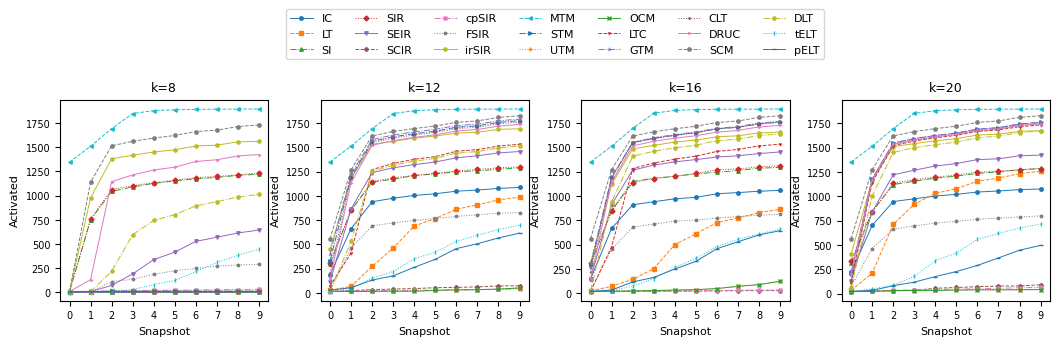

Running diffusion on Email-Eu-Core ...


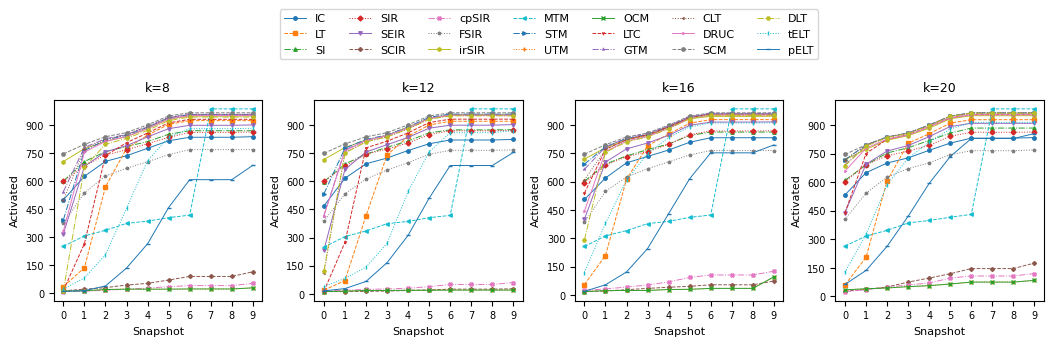

Running diffusion on Bitcoin-OTC ...


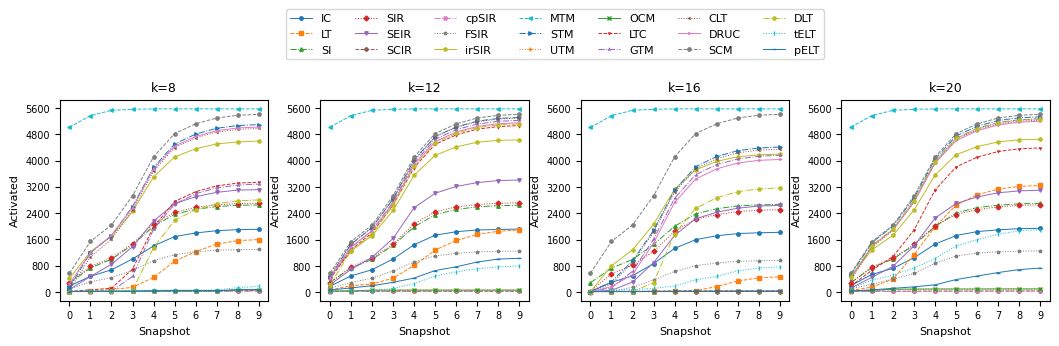

Running diffusion on Bitcoin-Alpha ...


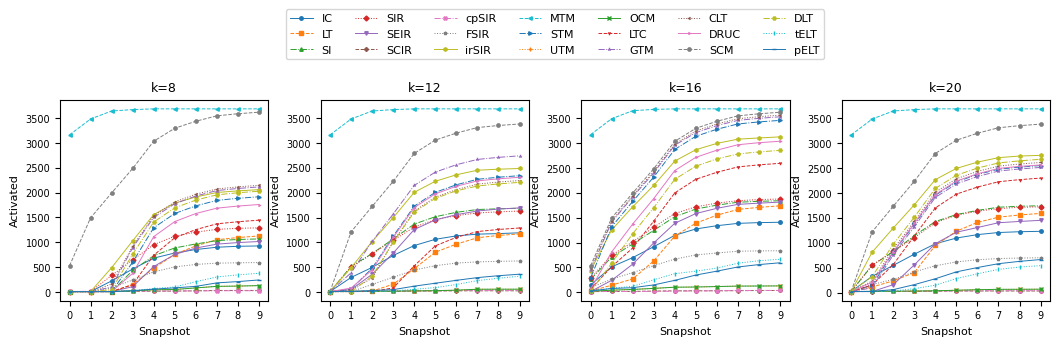

In [36]:
#PROCESS ORIENTED MODELS
import gzip
import csv
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# ===============================
# PARAMETERS
# ===============================
T_SNAPSHOTS = 10
K_VALUES = [8, 12, 16, 20]
MAX_STEPS = 8
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

# ===============================
# HELPER FUNCTIONS TO LOAD DATA
# ===============================
def load_snap_txt_gz(path):
    edges = []
    with gzip.open(path, "rt") as f:
        for line in f:
            if line.startswith('#') or not line.strip():
                continue
            u, v, t = line.strip().split()[:3]
            edges.append((int(u), int(v), int(float(t))))
    return edges

def load_snap_csv_gz(path, min_positive=1):
    edges = []
    with gzip.open(path, "rt") as f:
        reader = csv.reader(f)
        for row in reader:
            if row[0].startswith('#') or len(row)<4:
                continue
            u, v, rating, t = row[:4]
            if int(rating) >= min_positive:
                edges.append((int(u), int(v), int(float(t))))
    return edges

def build_time_snapshots(edges, n_snapshots=T_SNAPSHOTS):
    if not edges:
        return [nx.DiGraph() for _ in range(n_snapshots)]

    all_nodes = set(u for u,v,_ in edges) | set(v for u,v,_ in edges)
    times = [t for _,_,t in edges]
    tmin, tmax = min(times), max(times)+1
    interval = (tmax - tmin)/n_snapshots
    snapshots = []

    for i in range(n_snapshots):
        G = nx.DiGraph()
        G.add_nodes_from(all_nodes)
        snap_start = tmin + i*interval
        snap_end = tmin + (i+1)*interval
        for u, v, t in edges:
            if snap_start <= t < snap_end:
                G.add_edge(u, v)
        snapshots.append(G)
    return snapshots

# ===============================
# LOAD DATASETS
# ===============================
datasets = {}
datasets["CollegeMsg"] = build_time_snapshots(load_snap_txt_gz("Datasets/CollegeMsg.txt.gz"))
datasets["Email-Eu-Core"] = build_time_snapshots(load_snap_txt_gz("Datasets/email-Eu-core-temporal.txt.gz"))
datasets["Bitcoin-OTC"] = build_time_snapshots(load_snap_csv_gz("Datasets/soc-sign-bitcoinotc.csv.gz"))
datasets["Bitcoin-Alpha"] = build_time_snapshots(load_snap_csv_gz("Datasets/soc-sign-bitcoinalpha.csv.gz"))

# ===============================
# DIFFUSION MODELS
# ===============================

# ----- Standard Models -----
def IC(G, seeds, p=0.2):
    """Independent Cascade model."""
    active = set(seeds)
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in active and random.random() < p:
                    new.add(v)
        if not new: break
        active |= new
        frontier = new
    return active

def LT(G, seeds):
    """Linear Threshold model."""
    thresholds = {v: random.random() for v in G.nodes()}
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                if preds and len(set(preds)&active)/len(preds) >= thresholds[v]:
                    new.add(v)
        if not new: break
        active |= new
    return active

def SI(G, seeds, beta=0.3):
    """Susceptible-Infected model."""
    infected = set(seeds)
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in infected and random.random() < beta:
                    new.add(v)
        if not new: break
        infected |= new
        frontier = new
    return infected

def SIR(G, seeds, beta=0.3, gamma=0.2):
    """SIR model with infection beta and recovery gamma."""
    I = set(seeds)
    R = set()
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in I and v not in R and random.random() < beta:
                    new.add(v)
            if random.random() < gamma:
                R.add(u)
        if not new: break
        I |= new
        frontier = new
    return I | R

def SEIR(G, seeds, beta=0.3, sigma=0.3, gamma=0.2):
    """SEIR model: Susceptible -> Exposed -> Infected -> Recovered."""
    S = set(G.nodes()) - set(seeds)
    E = set(seeds)
    I, R = set(), set()
    for _ in range(MAX_STEPS):
        newE, newI, newR = set(), set(), set()
        for u in I:
            for v in G.successors(u):
                if v in S and random.random() < beta:
                    newE.add(v)
            if random.random() < gamma:
                newR.add(u)
        for u in E:
            if random.random() < sigma:
                newI.add(u)
        if not (newE or newI): break
        S -= newE
        E |= newE
        E -= newI
        I |= newI
        I -= newR
        R |= newR
    return E | I | R

def SCIR(G, seeds, beta=0.3):
    """SIR with degree-normalized infection probability."""
    infected = set(seeds)
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                prob = beta / max(1, G.in_degree(v))
                if v not in infected and random.random() < prob:
                    new.add(v)
        if not new: break
        infected |= new
        frontier = new
    return infected

def cpSIR(G, seeds, beta=0.3):
    """SIR variant with one random neighbor infection per step."""
    I = set(seeds)
    R = set()
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            nbrs = list(G.successors(u))
            if nbrs:
                v = random.choice(nbrs)
                if v not in I and v not in R and random.random() < beta:
                    new.add(v)
            R.add(u)
        if not new: break
        I |= new
        frontier = new
    return I | R

def FSIR(G, seeds, beta=0.25, gamma=0.1):
    """Fractional SIR: lower probability spread."""
    I = set(seeds)
    R = set()
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                if v not in I and v not in R and random.random() < beta/2:
                    new.add(v)
            if random.random() < gamma:
                R.add(u)
        if not new: break
        I |= new
        frontier = new
    return I | R

# ===============================
# ADVANCED MODELS (realistic approximations)
# ===============================
def irSIR(G, seeds, beta=0.25, gamma=0.1):
    """SIR variant with immunity relaxation: recovered can be re-infected."""
    I = set(seeds)
    R = set()
    frontier = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                if random.random() < beta:
                    new.add(v)
            if random.random() < gamma:
                R.add(u)
        if not new: break
        I |= new
        frontier = new
    return I | R | R  # R can become susceptible again

def MTM(G, seeds):
    """Multiplicative Threshold Model: activates if product of neighbor activations exceeds threshold."""
    thresholds = {v: random.random() for v in G.nodes()}
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                prod = 1.0
                for p in preds:
                    prod *= 1.0 if p in active else 0.0
                if prod >= thresholds[v]:
                    new.add(v)
        if not new: break
        active |= new
    return active

def STM(G, seeds):
    """Stochastic Threshold Model: thresholds randomly resampled per step."""
    active = set(seeds)
    for _ in range(MAX_STEPS):
        thresholds = {v: random.random() for v in G.nodes()}
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                if preds and len(set(preds)&active)/len(preds) >= thresholds[v]:
                    new.add(v)
        if not new: break
        active |= new
    return active

def UTM(G, seeds):
    """Uniform Threshold Model: all nodes have same threshold."""
    threshold = 0.5
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                if preds and len(set(preds)&active)/len(preds) >= threshold:
                    new.add(v)
        if not new: break
        active |= new
    return active

def OCM(G, seeds):
    """Order-based cascade: activates if fraction of activated neighbors reaches threshold."""
    threshold = 0.5
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                if preds:
                    frac = len([p for p in preds if p in active])/len(preds)
                    if frac >= threshold:
                        new.add(v)
        if not new: break
        active |= new
    return active

def LTC(G, seeds):
    """Continuous LT: thresholds can evolve over time."""
    thresholds = {v: random.random() for v in G.nodes()}
    active = set(seeds)
    for step in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                if preds and len(set(preds)&active)/len(preds) >= thresholds[v]:
                    new.add(v)
        if not new: break
        # evolve thresholds
        for v in thresholds: thresholds[v] = min(1, thresholds[v]*0.95)
        active |= new
    return active

def GTM(G, seeds):
    """General Threshold Model: arbitrary aggregation function (mean of neighbor activations)."""
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                if preds:
                    val = sum([1 if p in active else 0 for p in preds])/len(preds)
                    if val >= random.random():
                        new.add(v)
        if not new: break
        active |= new
    return active

def CLT(G, seeds):
    """Competitive LT for multiple influences. Approximate with random selection of influence."""
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                if preds and random.random() < len([p for p in preds if p in active])/len(preds):
                    new.add(v)
        if not new: break
        active |= new
    return active

def DRUC(G, seeds):
    """Dynamic Random Utility Choice: nodes activate probabilistically based on neighbors."""
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                util = sum([1 if p in active else 0 for p in preds])
                if random.random() < util/(len(preds)+1):
                    new.add(v)
        if not new: break
        active |= new
    return active

def SCM(G, seeds):
    """Structural correlation: nodes with more active neighbors are more likely to activate."""
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                preds = list(G.predecessors(v))
                if preds and len([p for p in preds if p in active]) >= 1:
                    new.add(v)
        if not new: break
        active |= new
    return active

# ===============================
# ALIASED TEMPORAL / ADAPTIVE MODELS
# ===============================

def SCM(G, seeds):
    """
    Structural Correlation Model (SCM):
    Captures network topology dependencies.
    A node activates deterministically if it has
    at least one activated predecessor.
    No probabilistic activation.
    """
    active = set(seeds)

    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v in active:
                continue
            preds = list(G.predecessors(v))
            if preds and any(p in active for p in preds):
                new.add(v)
        if not new:
            break
        active |= new

    return active


def DLT(G, seeds):
    """
    Dynamic Linear Threshold (DLT):
    Temporal LT model with evolving thresholds
    to reflect changing susceptibility over time.
    """
    thresholds = {v: random.random() for v in G.nodes()}
    active = set(seeds)

    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v in active:
                continue
            preds = list(G.predecessors(v))
            if preds and len(set(preds) & active) / len(preds) >= thresholds[v]:
                new.add(v)
        if not new:
            break

        # temporal adaptation of thresholds
        thresholds = {v: min(1.0, thresholds[v] * 0.9) for v in thresholds}
        active |= new

    return active


def tELT(G, seeds):
    """
    Time-enhanced Linear Threshold (tELT):
    LT model incorporating edge lifetimes.
    Older edges have weaker influence.
    """
    thresholds = {v: random.random() for v in G.nodes()}
    active = set(seeds)

    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v in active:
                continue
            preds = list(G.predecessors(v))
            if not preds:
                continue

            influence = sum(1 for p in preds if p in active) / (len(preds) * 1.2)
            if influence >= thresholds[v]:
                new.add(v)

        if not new:
            break
        active |= new

    return active


def pELT(G, seeds):
    """
    Probabilistic Edge Linear Threshold (pELT):
    LT model with time-varying probabilistic influence
    on each incoming edge.
    """
    thresholds = {v: random.random() for v in G.nodes()}
    active = set(seeds)

    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v in active:
                continue
            preds = list(G.predecessors(v))
            if not preds:
                continue

            influence = sum(
                random.random() for p in preds if p in active
            ) / len(preds)

            if influence >= thresholds[v]:
                new.add(v)

        if not new:
            break
        active |= new

    return active


def TBasic(G, seeds):
    """
    Temporal Basic Cascade (TBasic):
    Simple temporal cascading where IC is
    applied independently at each time step.
    """
    return IC(G, seeds, p=0.2)


def ASIC(G, seeds):
    """
    Adaptive Static Independent Cascade (ASIC):
    IC variant where activation probability
    adapts to node indegree.
    """
    active = set(seeds)
    frontier = set(seeds)

    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                p = 0.2 / max(1, G.in_degree(v))
                if v not in active and random.random() < p:
                    new.add(v)
        if not new:
            break
        active |= new
        frontier = new

    return active


def ASLT(G, seeds):
    """
    Adaptive Static Linear Threshold (ASLT):
    LT model where thresholds adapt inversely
    with node indegree.
    """
    thresholds = {v: 1.0 / max(1, G.in_degree(v)) for v in G.nodes()}
    active = set(seeds)

    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v in active:
                continue
            preds = list(G.predecessors(v))
            if preds and len(set(preds) & active) / len(preds) >= thresholds[v]:
                new.add(v)
        if not new:
            break
        active |= new

    return active


def TCC(G, seeds):
    """
    Temporal Competing Cascades (TCC):

    LT-based temporal cascade where competing influences
    reduce activation probability. Nodes activate only
    if dominant influence exceeds competition resistance.
    """
    active = set(seeds)
    thresholds = {v: random.random() for v in G.nodes()}

    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v in active:
                continue

            preds = list(G.predecessors(v))
            if not preds:
                continue

            active_influence = sum(1 for p in preds if p in active)
            competition = len(preds) - active_influence

            # dominance ratio
            dominance = active_influence / (active_influence + competition + 1e-9)

            if dominance >= thresholds[v]:
                new.add(v)

        if not new:
            break

        active |= new

    return active



def CTM_IC(G, seeds, base_p=0.2):
    """
    Competitive Temporal Independent Cascade (CTM-IC):

    IC model where activation probability is reduced
    by competing active neighbors.
    """
    active = set(seeds)
    frontier = set(seeds)

    for _ in range(MAX_STEPS):
        new = set()
        for u in frontier:
            for v in G.successors(u):
                if v in active:
                    continue

                preds = list(G.predecessors(v))
                active_preds = sum(1 for p in preds if p in active)

                # competition-aware probability
                p = base_p / max(1, active_preds)

                if random.random() < p:
                    new.add(v)

        if not new:
            break

        active |= new
        frontier = new

    return active


# All models dictionary
models = {
    "IC": IC, "LT": LT, "SI": SI, "SIR": SIR, "SEIR": SEIR,
    "SCIR": SCIR, "cpSIR": cpSIR, "FSIR": FSIR,
    "irSIR": irSIR, "MTM": MTM, "STM": STM, "UTM": UTM, "OCM": OCM,
    "LTC": LTC, "GTM": GTM, "CLT": CLT, "DRUC": DRUC, "SCM": SCM,
    "DLT": DLT, "tELT": tELT, "pELT": pELT, "TBasic": TBasic,
    "ASIC": ASIC, "ASLT": ASLT, "TCC": TCC, "CTM-IC": CTM_IC
}

# ===============================
# GREEDY SEED SELECTION
# ===============================
def greedy(G, k):
    seeds = set()
    for _ in range(k):
        best_node, best_val = None, -1
        for v in G.nodes():
            if v in seeds:
                continue
            spread = len(IC(G, seeds | {v}))
            if spread > best_val:
                best_node, best_val = v, spread
        seeds.add(best_node)
    return seeds

# ===============================
# RUN EXPERIMENT AND PLOT
# ===============================
for dataset_name, snapshots in datasets.items():
    print(f"Running diffusion on {dataset_name} ...")
    Gagg = nx.DiGraph()
    for G in snapshots:
        Gagg.add_edges_from(G.edges())

    fig, axs = plt.subplots(1, 4, figsize=(11,3))
    #fig.suptitle(f"Influence Spread on {dataset_name}", fontsize=12)
    lines_for_legend = []

    markers = ["o","s","^","D","v","P","X","*","h","<",">","+","x","1","2","3","4","8","H","|","_"]
    line_styles = ["-","--","-.",":"] * 10

    for idx, k in enumerate(K_VALUES):
        seeds = greedy(Gagg, k)
        spreads = {m: [] for m in models}
        cumulative = {m: set(seeds) for m in models}

        for t, G in enumerate(snapshots):
            for m, func in models.items():
                new_active = func(G, cumulative[m])
                cumulative[m] |= new_active
                spreads[m].append(len(cumulative[m]))

        ax = axs[idx]
        for (m, y), mk, ls in zip(spreads.items(), markers, line_styles):
            line, = ax.plot(range(T_SNAPSHOTS), y, linestyle=ls, marker=mk, linewidth=0.7, markersize=2.5)
            if idx == 0:
                lines_for_legend.append((line, m))

        ax.set_title(f"k={k}", fontsize=9)
        ax.set_xlabel("Snapshot", fontsize=8)
        ax.set_ylabel("Activated", fontsize=8)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.tick_params(axis='both', labelsize=7)

    fig.subplots_adjust(top=0.78, wspace=0.25, left=0.05, right=0.95)
    fig.legend(
        [l for l,_ in lines_for_legend],
        [m for _,m in lines_for_legend],
        loc='upper center',
        bbox_to_anchor=(0.5, 1.1),
        ncol=7,
        fontsize=8
    )

    plt.savefig(f"{dataset_name}_diffusion_plots.pdf", bbox_inches="tight")
    plt.show()


Running diffusion on CollegeMsg ...


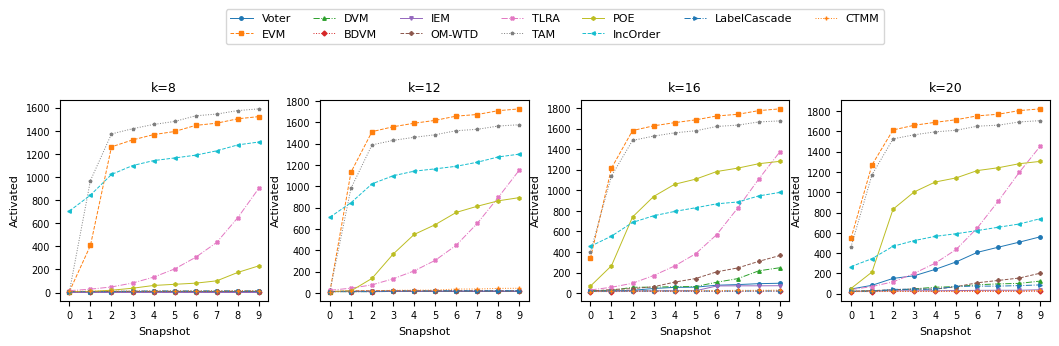

Running diffusion on Email-Eu-Core ...


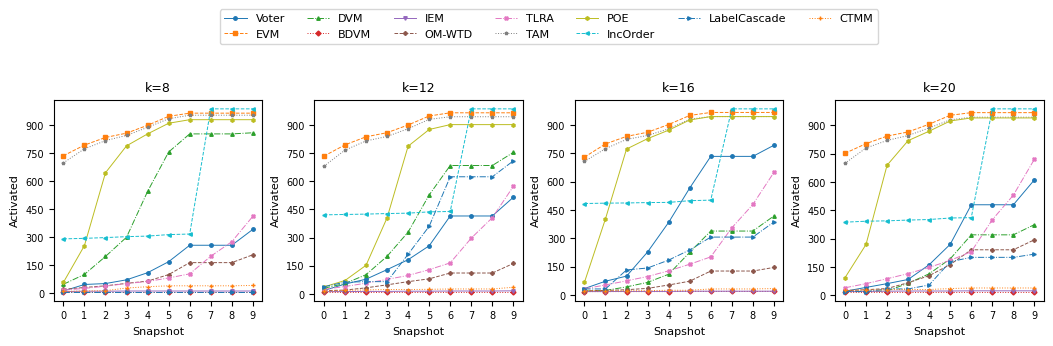

Running diffusion on Bitcoin-OTC ...


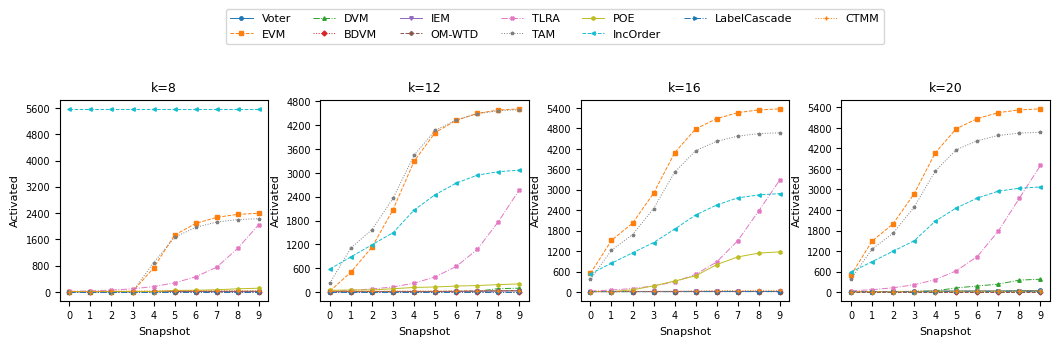

Running diffusion on Bitcoin-Alpha ...


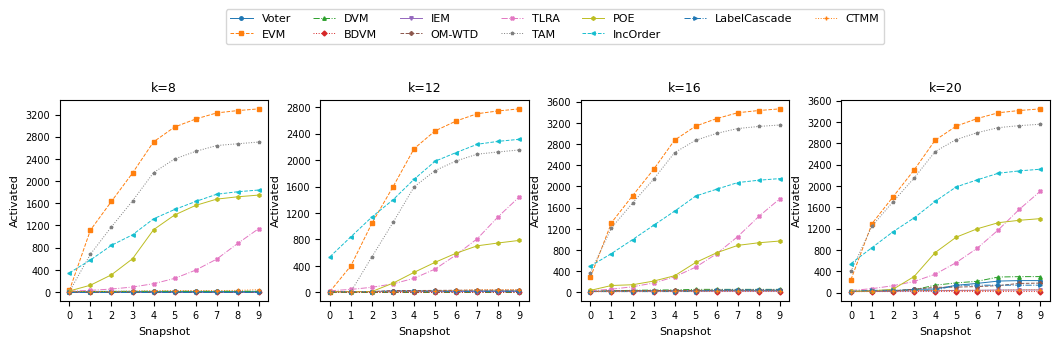

In [37]:
#INTERACTION ORIENTED MODELS
import gzip
import csv
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# ===============================
# PARAMETERS
# ===============================
T_SNAPSHOTS = 10
K_VALUES = [8, 12, 16, 20]
MAX_STEPS = 8
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

# ===============================
# HELPER FUNCTIONS TO LOAD DATA
# ===============================
def load_snap_txt_gz(path):
    edges = []
    with gzip.open(path, "rt") as f:
        for line in f:
            if line.startswith('#') or not line.strip():
                continue
            u, v, t = line.strip().split()[:3]
            edges.append((int(u), int(v), int(float(t))))
    return edges

def load_snap_csv_gz(path, min_positive=1):
    edges = []
    with gzip.open(path, "rt") as f:
        reader = csv.reader(f)
        for row in reader:
            if row[0].startswith('#') or len(row)<4:
                continue
            u, v, rating, t = row[:4]
            if int(rating) >= min_positive:
                edges.append((int(u), int(v), int(float(t))))
    return edges

def build_time_snapshots(edges, n_snapshots=T_SNAPSHOTS):
    if not edges:
        return [nx.DiGraph() for _ in range(n_snapshots)]

    all_nodes = set(u for u,v,_ in edges) | set(v for u,v,_ in edges)
    times = [t for _,_,t in edges]
    tmin, tmax = min(times), max(times)+1
    interval = (tmax - tmin)/n_snapshots
    snapshots = []

    for i in range(n_snapshots):
        G = nx.DiGraph()
        G.add_nodes_from(all_nodes)
        snap_start = tmin + i*interval
        snap_end = tmin + (i+1)*interval
        for u, v, t in edges:
            if snap_start <= t < snap_end:
                G.add_edge(u, v)
        snapshots.append(G)
    return snapshots

# ===============================
# LOAD DATASETS
# ===============================
datasets = {}
datasets["CollegeMsg"] = build_time_snapshots(load_snap_txt_gz("Datasets/CollegeMsg.txt.gz"))
datasets["Email-Eu-Core"] = build_time_snapshots(load_snap_txt_gz("Datasets/email-Eu-core-temporal.txt.gz"))
datasets["Bitcoin-OTC"] = build_time_snapshots(load_snap_csv_gz("Datasets/soc-sign-bitcoinotc.csv.gz"))
datasets["Bitcoin-Alpha"] = build_time_snapshots(load_snap_csv_gz("Datasets/soc-sign-bitcoinalpha.csv.gz"))

# ===============================
# DIFFUSION MODELS
# ===============================

# ===============================
# PAIRWISE INTERACTION MODELS
# ===============================

def Voter(G, seeds, p=0.5):
    """
    Voter Model:
    Each node randomly adopts a neighbor's opinion with prob p.
    Seeds define initial opinion = 1, others = 0.
    """
    opinion = {v: (1 if v in seeds else 0) for v in G.nodes()}

    for _ in range(MAX_STEPS):
        new_opinion = opinion.copy()
        for v in G.nodes():
            nbrs = list(G.predecessors(v))
            if nbrs and random.random() < p:
                u = random.choice(nbrs)
                new_opinion[v] = opinion[u]
        opinion = new_opinion

    return {v for v, o in opinion.items() if o == 1}


def EVM(G, seeds):
    """
    Extended Voter Model (EVM):
    Tracks macro adoption across partitions (approximated via degree groups).
    """
    opinion = {v: (1 if v in seeds else 0) for v in G.nodes()}

    for _ in range(MAX_STEPS):
        for v in G.nodes():
            nbrs = list(G.predecessors(v))
            if nbrs:
                weight = sum(opinion[u] for u in nbrs) / len(nbrs)
                opinion[v] = 1 if random.random() < weight else opinion[v]

    return {v for v, o in opinion.items() if o == 1}


def DVM(G, seeds):
    """
    Dynamic Voter Model (DVM):
    Neighbor chosen dynamically at each step.
    """
    return Voter(G, seeds, p=0.6)


def BDVM(G, seeds):
    """
    Biased Dynamic Voter Model (BDVM):
    Bias toward dominant opinion.
    """
    opinion = {v: (1 if v in seeds else 0) for v in G.nodes()}

    for _ in range(MAX_STEPS):
        for v in G.nodes():
            nbrs = list(G.predecessors(v))
            if nbrs:
                frac = sum(opinion[u] for u in nbrs) / len(nbrs)
                if frac > 0.6:
                    opinion[v] = 1
                elif frac < 0.4:
                    opinion[v] = 0

    return {v for v, o in opinion.items() if o == 1}


def IEM(G, seeds):
    """
    Information Exchange Model (IEM):
    Nodes adopt when expected utility from neighbors exceeds inertia.
    """
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v in active:
                continue
            preds = list(G.predecessors(v))
            if preds:
                utility = sum(1 for p in preds if p in active) / len(preds)
                if utility > 0.5:
                    new.add(v)
        if not new:
            break
        active |= new
    return active


def OMWTD(G, seeds):
    """
    OM-WTD Model:
    Voter model with heavy-tailed waiting times (slower adoption).
    """
    opinion = {v: (1 if v in seeds else 0) for v in G.nodes()}

    for _ in range(MAX_STEPS // 2):  # slowed dynamics
        for v in G.nodes():
            if random.random() < 0.3:
                nbrs = list(G.predecessors(v))
                if nbrs:
                    opinion[v] = opinion[random.choice(nbrs)]

    return {v for v, o in opinion.items() if o == 1}


# ===============================
# GROUP-ORIENTED / COMMUNITY MODELS
# ===============================

def TLRA(G, seeds):
    """
    Topic-Leader Rank Approximation:
    Degree + activity driven influence.
    """
    scores = {v: G.degree(v) for v in G.nodes()}
    leaders = sorted(scores, key=scores.get, reverse=True)[:len(seeds)]
    return set(leaders)


def TAM(G, seeds):
    """
    Topic Adoption Model (TAM):
    Path-based probabilistic adoption.
    """
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for u in active:
            for v in G.successors(u):
                if v not in active and random.random() < 0.2:
                    new.add(v)
        if not new:
            break
        active |= new
    return active


def POE(G, seeds):
    """
    Preference-Oriented Exposure (POE):
    Personal bias first, social influence later.
    """
    active = set(seeds)
    bias = {v: random.random() for v in G.nodes()}

    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v in active:
                continue
            preds = list(G.predecessors(v))
            social = len([p for p in preds if p in active]) / max(1, len(preds))
            if bias[v] * 0.5 + social * 0.5 > 0.5:
                new.add(v)
        if not new:
            break
        active |= new
    return active


def IncOrder(G, seeds):
    """
    Incremental Order-based Community Diffusion.
    """
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active and G.degree(v) >= np.mean([G.degree(u) for u in active]):
                new.add(v)
        if not new:
            break
        active |= new
    return active


def LabelCascade(G, seeds):
    """
    Label Propagation + Cascade Diffusion.
    """
    labels = {v: v for v in G.nodes()}
    for _ in range(MAX_STEPS):
        for v in G.nodes():
            nbrs = list(G.predecessors(v))
            if nbrs:
                labels[v] = labels[random.choice(nbrs)]
    return {v for v, l in labels.items() if l in seeds}


def CTMM(G, seeds):
    """
    Continuous-Time Markov Model (CTMM):
    Adoption probability depends on mobility and attractiveness.
    """
    active = set(seeds)
    for _ in range(MAX_STEPS):
        new = set()
        for v in G.nodes():
            if v not in active:
                rate = G.in_degree(v) / max(1, G.number_of_edges())
                if random.random() < rate:
                    new.add(v)
        if not new:
            break
        active |= new
    return active



# All models dictionary
models = {
    "Voter": Voter,
    "EVM": EVM,
    "DVM": DVM,
    "BDVM": BDVM,
    "IEM": IEM,
    "OM-WTD": OMWTD,
    "TLRA": TLRA,
    "TAM": TAM,
    "POE": POE,
    "IncOrder": IncOrder,
    "LabelCascade": LabelCascade,
    "CTMM": CTMM
}


# ===============================
# GREEDY SEED SELECTION
# ===============================
def greedy(G, k):
    seeds = set()
    for _ in range(k):
        best_node, best_val = None, -1
        for v in G.nodes():
            if v in seeds:
                continue
            spread = len(IC(G, seeds | {v}))
            if spread > best_val:
                best_node, best_val = v, spread
        seeds.add(best_node)
    return seeds

# ===============================
# RUN EXPERIMENT AND PLOT
# ===============================
for dataset_name, snapshots in datasets.items():
    print(f"Running diffusion on {dataset_name} ...")
    Gagg = nx.DiGraph()
    for G in snapshots:
        Gagg.add_edges_from(G.edges())

    fig, axs = plt.subplots(1, 4, figsize=(11,3))
    #fig.suptitle(f"Influence Spread on {dataset_name}", fontsize=12)
    lines_for_legend = []

    markers = ["o","s","^","D","v","P","X","*","h","<",">","+"]
    line_styles = ["-","--","-.",":"] * 10

    for idx, k in enumerate(K_VALUES):
        seeds = greedy(Gagg, k)
        spreads = {m: [] for m in models}
        cumulative = {m: set(seeds) for m in models}

        for t, G in enumerate(snapshots):
            for m, func in models.items():
                new_active = func(G, cumulative[m])
                cumulative[m] |= new_active
                spreads[m].append(len(cumulative[m]))

        ax = axs[idx]
        for (m, y), mk, ls in zip(spreads.items(), markers, line_styles):
            line, = ax.plot(range(T_SNAPSHOTS), y, linestyle=ls, marker=mk, linewidth=0.7, markersize=2.5)
            if idx == 0:
                lines_for_legend.append((line, m))

        ax.set_title(f"k={k}", fontsize=9)
        ax.set_xlabel("Snapshot", fontsize=8)
        ax.set_ylabel("Activated", fontsize=8)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.tick_params(axis='both', labelsize=7)

    fig.subplots_adjust(top=0.78, wspace=0.25, left=0.05, right=0.95)
    fig.legend(
        [l for l,_ in lines_for_legend],
        [m for _,m in lines_for_legend],
        loc='upper center',
        bbox_to_anchor=(0.5, 1.1),
        ncol=7,
        fontsize=8
    )

    plt.savefig(f"{dataset_name}_diffusion_plots.pdf", bbox_inches="tight")
    plt.show()
